
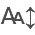

In [150]:
from pathlib import Path
import datetime
import json
import gzip
import gc
from itertools import chain
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import ipywidgets as widgets

from itables import init_notebook_mode
from itables.widget import ITable

# Initialise itables
init_notebook_mode(all_interactive=True, connected=False)

# Set directories
RAW_DIR = Path("bmrs_raw")
CSV_DIR = Path("bmrs_csv_interpolated")

# Date range
start_date = "2017-01-01"
end_date   = "2025-05-31"


# DATA PRE-PROCESSING

## BUILDING THE FINAL .csv FROM .json

* **Imports & configuration** – import `json`, `gzip`, `pathlib`, `itertools`, `pandas`, `tqdm`, `numpy`; set `RAW_DIR`, `CSV_DIR`, and the global `start_date`/`end_date`.

* **Raw JSON loading** – `_load_json_z` reads a single `.json.gz`; `_folder_to_df` concatenates all files in a folder into one DataFrame.

* **Timestamp construction** – `build_start_time` returns a UTC‐like `startTime` column, either from an existing field or by combining `settlementDate`+`settlementPeriod`.

* **Type coercion** – `_coerce_type` downcasts non-key columns to `float32` and normalises the date/time columns to naïve `datetime64[ns]`.

* **Small-gap interpolation** – `fill_small_gaps` linearly fills runs of up to two missing half-hours in numeric columns, leaving longer gaps untouched.

* **UK half-hour calendar** – `build_uk_halfhour_calendar` generates a full DST-aware sequence of half-hour intervals between any two dates.

* **Padding missing intervals** – `_pad_missing` merges data onto the full calendar (trimming to the global date range) so every expected interval appears.

* **Finalising pipeline** – `_finish` selects the requested columns, coerces types, pads missing, drops duplicates, interpolates small gaps, then sorts and resets the index.

* **Dataset builders** – each `b_<dataset>` function (e.g. `b_actual_demand`, `b_gen_per_type`, `b_system_prices`, etc.) computes `startTime`, selects its own `want` column list, and hands off to `_finish` to produce the final CSV.


In [ ]:
def _load_json_z(path: Path) -> list[dict]:
    with gzip.open(path, "rt") as fh:
        return json.load(fh)["data"]


def _folder_to_df(folder: Path) -> pd.DataFrame:
    files = sorted(folder.glob("*.json.gz"))
    rows  = chain.from_iterable((_load_json_z(f) for f in files))
    return pd.DataFrame.from_records(rows)


def build_start_time(df: pd.DataFrame) -> pd.Series:
    """Return UTC-like timestamp (start of settlement period)."""
    if "startTime" in df.columns:
        return pd.to_datetime(df["startTime"], errors="coerce")
    # otherwise compose from date + SP (SP1 = 00:00 UTC *winter*)
    base = pd.to_datetime(df["settlementDate"])
    off  = pd.to_timedelta(df["settlementPeriod"].astype(int).sub(1) * 30,
                           unit="m")
    return base + off




# ──────────────────────────────────────────────────────────────────────────
# ──────────────────────────────── finisher ────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────

KEY_COLS = {"startTime", "settlementDate", "settlementPeriod"}

def _coerce_type(df: pd.DataFrame) -> pd.DataFrame:
    """
    • convert every non-key column to float32
    • normalise / de-tz key date columns so they all share the
      *same* dtype (naïve datetime64[ns])
    """
    # 1) numeric columns  → float32
    num_cols = [c for c in df.columns if c not in KEY_COLS]
    df[num_cols] = df[num_cols].apply(
        pd.to_numeric, errors="coerce", downcast="float"
    )

    # 2) settlementDate  → 00:00 of that day, no timezone
    df["settlementDate"] = (
        pd.to_datetime(df["settlementDate"], utc=True)   # ensure tz-aware
          .dt.normalize()                                # strip hh:mm:ss
          .dt.tz_localize(None)                          # drop timezone
    )

    # 3) startTime  → no timezone (but keep hh:mm)
    if "startTime" in df.columns:
        df["startTime"] = (
            pd.to_datetime(df["startTime"], utc=True)
              .dt.tz_localize(None)
        )

    # settlementPeriod stays int32
    if "settlementPeriod" in df.columns:
        df["settlementPeriod"] = df["settlementPeriod"].astype("int32")

    return df

# ──────────────────────────────────────────────────────────────────────────

def fill_small_gaps(
    df: pd.DataFrame,
    time_col: str = "startTime",
    limit: int = 2,
    limit_direction: str = "both",
) -> pd.DataFrame:
    """
    Interpolate up to `limit` consecutive missing periods on numeric columns,
    leaving any longer runs untouched.

    Steps:
      1) sort by time_col and make it the DatetimeIndex
      2) full time-based interpolation on numeric columns
      3) for each numeric column, detect contiguous NaN runs
         and only accept interpolated values where run-length ≤ limit
      4) restore time_col as a column

    Parameters:
      df            DataFrame containing a datetime column + numeric columns
      time_col      name of the datetime column to use as index
      limit         maximum number of consecutive NaNs to fill
      limit_direction  “forward”, “backward” or “both” (passed to interpolate)

    Returns:
      DataFrame with small gaps filled, same columns as input.
    """
    # 1) sort & index by time
    out = df.sort_values(time_col).set_index(time_col)

    # 2) pick numeric columns and do full interpolation
    num_cols   = out.select_dtypes(include="number").columns
    full_interp = out[num_cols].interpolate(
        method="time",
        limit=None,
        limit_direction=limit_direction
    )

    # 3) for each numeric column, only keep fills for runs ≤ limit
    for col in num_cols:
        is_na = out[col].isna()
        grp   = (is_na != is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).transform("sum")
        can_fill = is_na & (runlen <= limit)

        # <-- write straight into `out` here -->
        out.loc[can_fill, col] = full_interp.loc[can_fill, col]
    # 4) restore time_col
    return out.reset_index()

# ──────────────────────────────────────────────────────────────────────────


def build_uk_halfhour_calendar(start_date, end_date):
    """
    Build UK half-hour calendar with correct DST handling:
      • Spring-forward days: 46 periods (including the skipped 01:00/01:30)
      • Normal days: 48 periods 00:00→23:30
      • BST days: 48 periods 23:00(prev day)→22:30
      • Autumn-back days: 50 periods 23:00(prev day)→22:30
    """
    # helper to normalize inputs
    def _to_date(x):
        if isinstance(x, str):
            # ISO?
            if x.count("-") == 2 and x[4] == "-":
                return datetime.date.fromisoformat(x)
            # else assume European
            return datetime.datetime.strptime(x, "%d/%m/%Y").date()
        if isinstance(x, pd.Timestamp):
            return x.date()
        return x  # already a date

    start = _to_date(start_date)
    end   = _to_date(end_date)

    london = ZoneInfo("Europe/London")
    utc    = ZoneInfo("UTC")
    rows   = []

    for single in pd.date_range(start, end, freq="D"):
        D   = single.date()
        # local midnights in London
        dt0 = datetime.datetime(D.year, D.month, D.day, tzinfo=london)
        dt1 = dt0 + datetime.timedelta(days=1)

        # number of half-hours that actually occur
        total_secs = (dt1.astimezone(utc) - dt0.astimezone(utc)).total_seconds()
        n_periods = int(total_secs // 1800)

        # align to UTC-naive base for SP1
        offset_h = dt0.utcoffset().total_seconds() / 3600
        if offset_h > 0:
            base = datetime.datetime(D.year, D.month, D.day) - datetime.timedelta(hours=int(offset_h))
        else:
            base = datetime.datetime(D.year, D.month, D.day)

        for i in range(n_periods):
            rows.append({
                "startTime":        base + datetime.timedelta(minutes=30 * i),
                "settlementDate":   D,
                "settlementPeriod": i + 1
            })

    df = pd.DataFrame(rows)

    # ─── coerce to pandas time types ───
    df["startTime"]      = pd.to_datetime(df["startTime"])
    df["settlementDate"] = pd.to_datetime(df["settlementDate"]).dt.normalize()
    df["settlementPeriod"] = df["settlementPeriod"].astype("int32")
    # ───────────────────────────────────

    return df


# ──────────────────────────────────────────────────────────────────────────

def _pad_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each settlementDate in df, build exactly the UK
    SP‐calendar via build_uk_halfhour_calendar(min,max), then
    left‐merge your data on (Date,Period,startTime).
    Also trims the input df to only include rows between start_date and end_date (inclusive).
    """
    if df.empty:
        return df

    df = df.copy()
    df=df.drop_duplicates(subset=["startTime"])
    # ensure proper types
    df["settlementDate"]   = pd.to_datetime(df["settlementDate"]).dt.normalize()
    df["settlementPeriod"] = df["settlementPeriod"].astype(int)
    df["startTime"]        = pd.to_datetime(df["startTime"])

    lo = start_date
    hi = end_date

    # trim input df to only include rows between start_date and end_date (inclusive)
    mask = (
        (df["settlementDate"] >= pd.to_datetime(start_date)) &
        (df["settlementDate"] <= pd.to_datetime(end_date))
    )
    df = df.loc[mask]

    # build the master calendar
    cal = build_uk_halfhour_calendar(lo, hi)
    cal["settlementDate"]   = pd.to_datetime(cal["settlementDate"])
    cal["settlementPeriod"] = cal["settlementPeriod"].astype(int)
    cal["startTime"]        = pd.to_datetime(cal["startTime"], dayfirst=True)

    # left‐join your actual data onto the calendar
    out = (
        cal
        .merge(df,
               on=["settlementDate","settlementPeriod","startTime"],
               how="left",
               sort=False)
    )

    return out

# ──────────────────────────────────────────────────────────────────────────

def _finish(out: pd.DataFrame, want: list[str]) -> pd.DataFrame:
    # 1) keep only requested columns
    out = out[want]
    # 2) downcast
    out = _coerce_type(out)
    # 3) pad missing with DST‐aware UK calendar
    out = _pad_missing(out)
    # 4) drop duplicate rows
    out = out.drop_duplicates()
    # 5) fill small gaps in numeric columns
    out = fill_small_gaps(out, time_col="startTime", limit=3)
    
    return out.sort_values("startTime").reset_index(drop=True)




# ──────────────────────────────────────────────────────────────────────────
# ──────────────────────────────── builders ────────────────────────────────
# ──────────────────────────────────────────────────────────────────────────

def b_actual_demand(df):
    df["startTime"] = build_start_time(df)
    want = ["startTime","settlementDate","settlementPeriod",
            "initialDemandOutturn",
            "initialTransmissionSystemDemandOutturn"]
    out = df[want]
    return _finish(out, want)

# ──────────────────────────────────────────────────────────────────────────
def _pivot_wind_solar(df, value_name):
    """Helper for AGWS / DGWS."""
    map_ = {
        "Wind Onshore" : "windOnshoreGeneration",
        "Wind Offshore": "windOffshoreGeneration",
        "Solar"        : "solarGeneration",
    }
    df  = df.replace({"psrType": map_})
    out = (df.pivot_table(index=["settlementDate","settlementPeriod","startTime"],
                          columns="psrType",
                          values=value_name, aggfunc="first")
             .reset_index())
    out["startTime"] = build_start_time(out)
    for c in map_.values():
        if c not in out.columns:
            out[c] = pd.NA
    return out


def b_actual_gen_ws(df):
    tidy = _pivot_wind_solar(df.rename(columns={"quantity":"gen"}),
                             "gen")
    want = ["startTime","settlementDate","settlementPeriod",
            "windOnshoreGeneration","windOffshoreGeneration",
            "solarGeneration"]
    out = tidy[want]
    return _finish(out, want)


def b_dayahead_gen_ws(df):
    tidy = _pivot_wind_solar(df.rename(columns={"quantity":"forecast"}),
                             "forecast")
    want = ["startTime","settlementDate","settlementPeriod",
            "windOnshoreGeneration","windOffshoreGeneration",
            "solarGeneration"]
    out = tidy[want]
    return _finish(out, want)

# ──────────────────────────────────────────────────────────────────────────
GEN_MAP = {
    "Hydro Pumped Storage":"hydroPumpedStorage",
    "Hydro Run-of-River"  :"hydroRunOfRiver",
    "Fossil Hard coal"    :"fossilCoal",
    "Fossil Gas"          :"fossilGas",
    "Fossil Oil"          :"fossilOil",
    "Nuclear"             :"nuclear",
    "Other"               :"other",
    "Wind Onshore"        :"windOnshore",
    "Wind Offshore"       :"windOffshore",
    "Solar"               :"solar",
}
def b_gen_per_type(df):
    df = (df.replace({"psrType": GEN_MAP})
            .pivot_table(index=["settlementDate","settlementPeriod","startTime"],
                         columns="psrType",
                         values="quantity", aggfunc="first")
            .reset_index())
    df["startTime"] = build_start_time(df)
    for col in GEN_MAP.values():
        if col not in df.columns:
            df[col] = pd.NA
    want = ["startTime","settlementDate","settlementPeriod"]+list(GEN_MAP.values())
    out = df[want]
    return _finish(out, want)

# ──────────────────────────────────────────────────────────────────────────
def b_dayahead_demand(df):
    df["startTime"] = build_start_time(df)
    want = ["startTime", "settlementDate", "settlementPeriod",
            "transmissionSystemDemand", "nationalDemand"]
    out = df[want]
    return _finish(out, want)


# ──────────────────────────────────────────────────────────────────────────
def b_indicated(df):
    df["startTime"] = build_start_time(df)
    want = ["startTime", "settlementDate", "settlementPeriod",
            "indicatedGeneration", "indicatedDemand",
            "indicatedMargin", "indicatedImbalance"]
    out = df[want]
    return _finish(out, want)


# ──────────────────────────────────────────────────────────────────────────
IC_NAME_TO_COL = {
    "Eleclink (INTELEC)"      : "INTELEC",
    "Ireland(East-West)"      : "INTEW",
    "France(IFA)"             : "INTFR",
    "Ireland (Greenlink)"     : "INTGRNL",
    "IFA2 (INTIFA2)"          : "INTIFA2",
    "Northern Ireland(Moyle)" : "INTIRL",
    "Netherlands(BritNed)"    : "INTNED",
    "Belgium (Nemolink)"      : "INTNEM",
    "North Sea Link (INTNSL)" : "INTNSL",
    "Denmark (Viking link)"   : "INTVKL",
}

def b_inter(df):
    df = df.replace({"interconnectorName": IC_NAME_TO_COL})

    df = (df.pivot_table(index=["settlementDate", "settlementPeriod", "startTime"],
                         columns="interconnectorName",
                         values="generation",
                         aggfunc="first")
            .reset_index())

    df["startTime"] = build_start_time(df)

    for col in IC_NAME_TO_COL.values():
        if col not in df.columns:
            df[col] = pd.NA

    want = ["startTime", "settlementDate", "settlementPeriod"] \
           + list(IC_NAME_TO_COL.values())
    out = df[want]
    return _finish(out, want)


# ──────────────────────────────────────────────────────────────────────────
def b_mid(df):
    # force a copy before any assignment
    df = df.loc[df["dataProvider"] == "APXMIDP"].copy()
    df["startTime"] = build_start_time(df)
    want = ["startTime", "settlementDate", "settlementPeriod",
            "price", "volume"]
    return _finish(df[want], want)


# ──────────────────────────────────────────────────────────────────────────
HORIZONS = [1, 2, 4, 8, 12]

def b_lolpdrm(df):
    df["startTime"] = build_start_time(df)

    # keep only horizons we care about
    df = df.loc[df["forecastHorizon"].isin(HORIZONS),
                ["startTime", "settlementDate", "settlementPeriod",
                 "forecastHorizon", "lossOfLoadProbability",
                 "deratedMargin"]]

    # ----------  LOLP (horizon 1)  ----------
    lolp = (df[df["forecastHorizon"] == 1]
              .rename(columns={"lossOfLoadProbability": "1hLOLP"})
              .loc[:, ["startTime", "settlementDate",
                       "settlementPeriod", "1hLOLP"]])

    # ----------  DRM (pivot all horizons)  ----------
    drm = (df.pivot_table(index=["startTime", "settlementDate",
                                 "settlementPeriod"],
                          columns="forecastHorizon",
                          values="deratedMargin")
             .rename(columns={h: f"{h}hDRM" for h in HORIZONS})
             .reset_index())

    # ----------  merge & order columns  ----------
    out = lolp.merge(drm, on=["startTime", "settlementDate",
                              "settlementPeriod"])

    want = ["startTime", "settlementDate", "settlementPeriod",
            "1hLOLP", "1hDRM", "2hDRM", "4hDRM", "8hDRM", "12hDRM"]
    out = out[want]
    return _finish(out, want)


# ──────────────────────────────────────────────────────────────────────────
def b_system_prices(df):
    df["startTime"] = build_start_time(df)

    df = df.rename(columns={
        "systemSellPrice"    : "systemPrice",      # SSP / SBP
        "netImbalanceVolume" : "netImbalanceVolume"
    })

    want = ["startTime", "settlementDate", "settlementPeriod",
            "systemPrice", "netImbalanceVolume",
            "sellPriceAdjustment", "buyPriceAdjustment",
            "replacementPrice", "replacementPriceReferenceVolume",
            "totalAcceptedOfferVolume", "totalAcceptedBidVolume",
            "totalAdjustmentSellVolume", "totalAdjustmentBuyVolume",
            "totalSystemTaggedAcceptedOfferVolume",
            "totalSystemTaggedAcceptedBidVolume",
            "totalSystemTaggedAdjustmentSellVolume",
            "totalSystemTaggedAdjustmentBuyVolume"]

    # create any missing columns so _finish keeps dtype order
    for col in want:
        if col not in df.columns:
            df[col] = pd.NA

    out = df[want]
    return _finish(out, want)


In [ ]:
BUILDERS = {
    "ACTUAL_DEMAND"            : b_actual_demand,
    "ACTUAL_GEN_WIND_SOLAR"    : b_actual_gen_ws,
    "DAYAHEAD_DEMAND"          : b_dayahead_demand,
    "DAYAHEAD_GEN_WIND_SOLAR"  : b_dayahead_gen_ws,
    "GEN_PER_TYPE"             : b_gen_per_type,
    "INDICATED_DAYAHEAD_DEMAND": b_indicated,
    "INTER"                    : b_inter,
    "LOLPDRM"                  : b_lolpdrm,
    "MID"                      : b_mid,
    "SYSTEM_PRICES"            : b_system_prices,
}

# ──────────────────────────────────────────────────────────────────────────

def process_one(code: str, builder):
    folder = RAW_DIR / code
    if not folder.exists():
        print(f"⚠ {code}: folder missing → skipped")
        return
    df_raw = _folder_to_df(folder)
    if df_raw.empty:
        print(f"⚠ {code}: empty → skipped")
        return
    df_tidy = builder(df_raw)
    out = CSV_DIR / f"{code}.csv"
    df_tidy.to_csv(out, index=False)
    print(f"✓ {code}: {len(df_tidy):,} rows → {out}")

def main():
    for code, builder in BUILDERS.items():
        process_one(code, builder)

if __name__ == "__main__":
    pd.set_option("future.no_silent_downcasting", True)
    main()


✓ ACTUAL_DEMAND: 147,502 rows → bmrs_csv_interpolated/ACTUAL_DEMAND.csv
✓ ACTUAL_GEN_WIND_SOLAR: 147,502 rows → bmrs_csv_interpolated/ACTUAL_GEN_WIND_SOLAR.csv
✓ DAYAHEAD_DEMAND: 147,502 rows → bmrs_csv_interpolated/DAYAHEAD_DEMAND.csv
✓ DAYAHEAD_GEN_WIND_SOLAR: 147,502 rows → bmrs_csv_interpolated/DAYAHEAD_GEN_WIND_SOLAR.csv
✓ GEN_PER_TYPE: 147,502 rows → bmrs_csv_interpolated/GEN_PER_TYPE.csv
✓ INDICATED_DAYAHEAD_DEMAND: 147,502 rows → bmrs_csv_interpolated/INDICATED_DAYAHEAD_DEMAND.csv
✓ INTER: 147,502 rows → bmrs_csv_interpolated/INTER.csv
✓ LOLPDRM: 147,502 rows → bmrs_csv_interpolated/LOLPDRM.csv
✓ MID: 147,502 rows → bmrs_csv_interpolated/MID.csv
✓ SYSTEM_PRICES: 147,502 rows → bmrs_csv_interpolated/SYSTEM_PRICES.csv


## Analysing Missing Data

In [ ]:
OUT_CSV = CSV_DIR / "all_feeds_missing.csv"

KEY_COLS = ["startTime", "settlementDate", "settlementPeriod"]

# 1) build a full DST-aware half-hour calendar
cal = build_uk_halfhour_calendar("01/01/2017", "31/05/2025")

skip_feeds = {"all_feeds_missing","MID","INTER","SYSTEM_PRICES","GEN_PER_TYPE"}

# 2) for each feed, detect its missing-data runs and merge
for csv_path in sorted(CSV_DIR.glob("*.csv")):
    feed = csv_path.stem
    if feed in skip_feeds:
        continue

    print("Processing", feed)
    df = pd.read_csv(csv_path, dtype=str)

    # — normalise the key columns to datetime64 —
    df["startTime"]      = (
        pd.to_datetime(df["startTime"], utc=True, errors="coerce")
          .dt.tz_convert(None)
    )
    df["settlementDate"] = (
        pd.to_datetime(df["settlementDate"], dayfirst=True, errors="coerce")
          .dt.normalize()
    )
    df["settlementPeriod"] = df["settlementPeriod"].astype(int)

    # — compute, row-wise, the list of missing data columns —
    data_cols = [c for c in df.columns if c not in KEY_COLS]
    missing = (
        df[data_cols].isna()
        | (df[data_cols] == "")
    ).apply(lambda row: ";".join(row.index[row]), axis=1)

    # — build the small DataFrame with exactly matching key dtypes —
    small = df[KEY_COLS].copy()
    small[feed] = missing

    # free memory from the big DataFrame
    del df
    gc.collect()

    # — merge on uniform dtypes (datetime64), fill & drop dupes —
    cal = cal.merge(small, on=KEY_COLS, how="left")
    cal[feed] = cal[feed].fillna("")
    cal.drop_duplicates(subset=["startTime"], inplace=True)

    del small
    gc.collect()

# 3) save the combined missing-data report
cal.to_csv(OUT_CSV, index=False)
print("→ Written combined missing-data report to", OUT_CSV)

Processing ACTUAL_DEMAND
Processing ACTUAL_GEN_WIND_SOLAR
Processing DAYAHEAD_DEMAND
Processing DAYAHEAD_GEN_WIND_SOLAR
Processing INDICATED_DAYAHEAD_DEMAND
Processing LOLPDRM
→ Written combined missing-data report to bmrs_csv_interpolated/all_feeds_missing.csv


In [ ]:
def gap_analysis(df: pd.DataFrame, time_col: str="startTime") -> pd.DataFrame:
    """
    Wide-form gap analysis:
      * index by gapSize
      * one column per series named <col>GapCount
      * each value = count of runs of that length
      * zeros where no runs of that size exist
    """
    # ensure chronological order & index on time_col
    df2 = df.sort_values(time_col).set_index(time_col)

    # pick every column except the three keys
    key_cols = {time_col, "settlementDate", "settlementPeriod"}
    candidate_cols = [c for c in df2.columns if c not in key_cols]

    rows = []
    for col in candidate_cols:
        ser   = pd.to_numeric(df2[col], errors="coerce")
        is_na = ser.isna()
        grp   = is_na.ne(is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).sum()
        runlen = runlen[runlen > 0]
        counts = runlen.value_counts().sort_index()
        for gap_size, cnt in counts.items():
            rows.append({
                "column_name": col,
                "gap_size":    int(gap_size),
                "count":       int(cnt),
            })

    long = pd.DataFrame(rows)
    if long.empty:
        cols = ["gapSize"] + [f"{c}GapCount" for c in candidate_cols]
        return pd.DataFrame(columns=cols)

    wide = (
        long
        .pivot(index="gap_size", columns="column_name", values="count")
        .fillna(0)
        .astype(int)
        .reset_index()
        .rename(columns={"gap_size": "gapSize"})
    )
    wide.columns = [
        c if c == "gapSize" else f"{c}GapCount"
        for c in wide.columns
    ]
    return wide

# ──────────────────────────────────────────────────────────────────────────

# prepare list of feeds
skip_feeds = {"all_feeds_missing", "MID", "INTER", "SYSTEM_PRICES", "GEN_PER_TYPE"}
paths      = sorted(CSV_DIR.glob("*.csv"))

# load raw DataFrames for each feed
dataframes, titles = [], []
for p in paths:
    name = p.stem
    if name in skip_feeds:
        continue
    df = pd.read_csv(p, parse_dates=["startTime"])
    dataframes.append(df)
    titles.append(name)

# create one Output per feed, and a Tab container
outs = [widgets.Output() for _ in dataframes]
tab  = widgets.Tab(children=outs)
for i, title in enumerate(titles):
    tab.set_title(i, title)

# callback: build and display the ITable when tab is selected
def _on_tab_change(change):
    if change["name"] != "selected_index":
        return
    idx = change["new"]
    df  = dataframes[idx]
    gaps = gap_analysis(df)
    out  = outs[idx]
    with out:
        clear_output(wait=True)
        tbl = ITable(
            gaps,
            classes="display nowrap",
            paging=False,   # disable pagination
            layout={        # remove all the UI controls
                "topStart":    None,  # no length-menu
                "topEnd":      None,  # no search box
                "bottomStart": None,  # no info text
                "bottomEnd":   None,  # no paging controls
            },
            scrollX=True
        )
        display(tbl)

tab.observe(_on_tab_change, names="selected_index")

# trigger initial display of the first tab
tab.selected_index = 1

# render the tabs
display(tab)


## Displaying the Data

In [26]:
# 1) load all CSVs into a dict
df_store = {
    p.stem: pd.read_csv(
        p,
        parse_dates=["startTime"],
        low_memory=False
    )
    for p in sorted(CSV_DIR.glob("*.csv"))
    if p.stem != "all_feeds_missing"
}

# 2) normalise settlementDate if present
for df in df_store.values():
    if "settlementDate" in df:
        df["settlementDate"] = pd.to_datetime(df["settlementDate"]).dt.normalize()

# 3) save all DataFrames to global variables
for name, df in df_store.items():
    globals()[name] = df

In [30]:
# Global Matplotlib configuration for publication‐quality figures
plt.rcParams.update({
    # Resolution
    "figure.dpi": 300,
    # Font
    "font.family": "Times New Roman",
    # Figure size (optional – adjust as needed)
    "figure.figsize": (10, 6),
    # Title and label font sizes
    "figure.titlesize": 18,    # overall figure title
    "axes.titlesize": 18,      # axes title
    "axes.labelsize": 14,      # x/y axis labels
    # Tick label size
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    # Legend
    "legend.fontsize": 12,
    # Line width (for plot lines)
    "lines.linewidth": 1.5,
    # Grid styling (optional)
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
})


### Imbalance Price

In [21]:
mid_path = CSV_DIR / "MID.csv"
mid = pd.read_csv(mid_path, parse_dates=["startTime"])

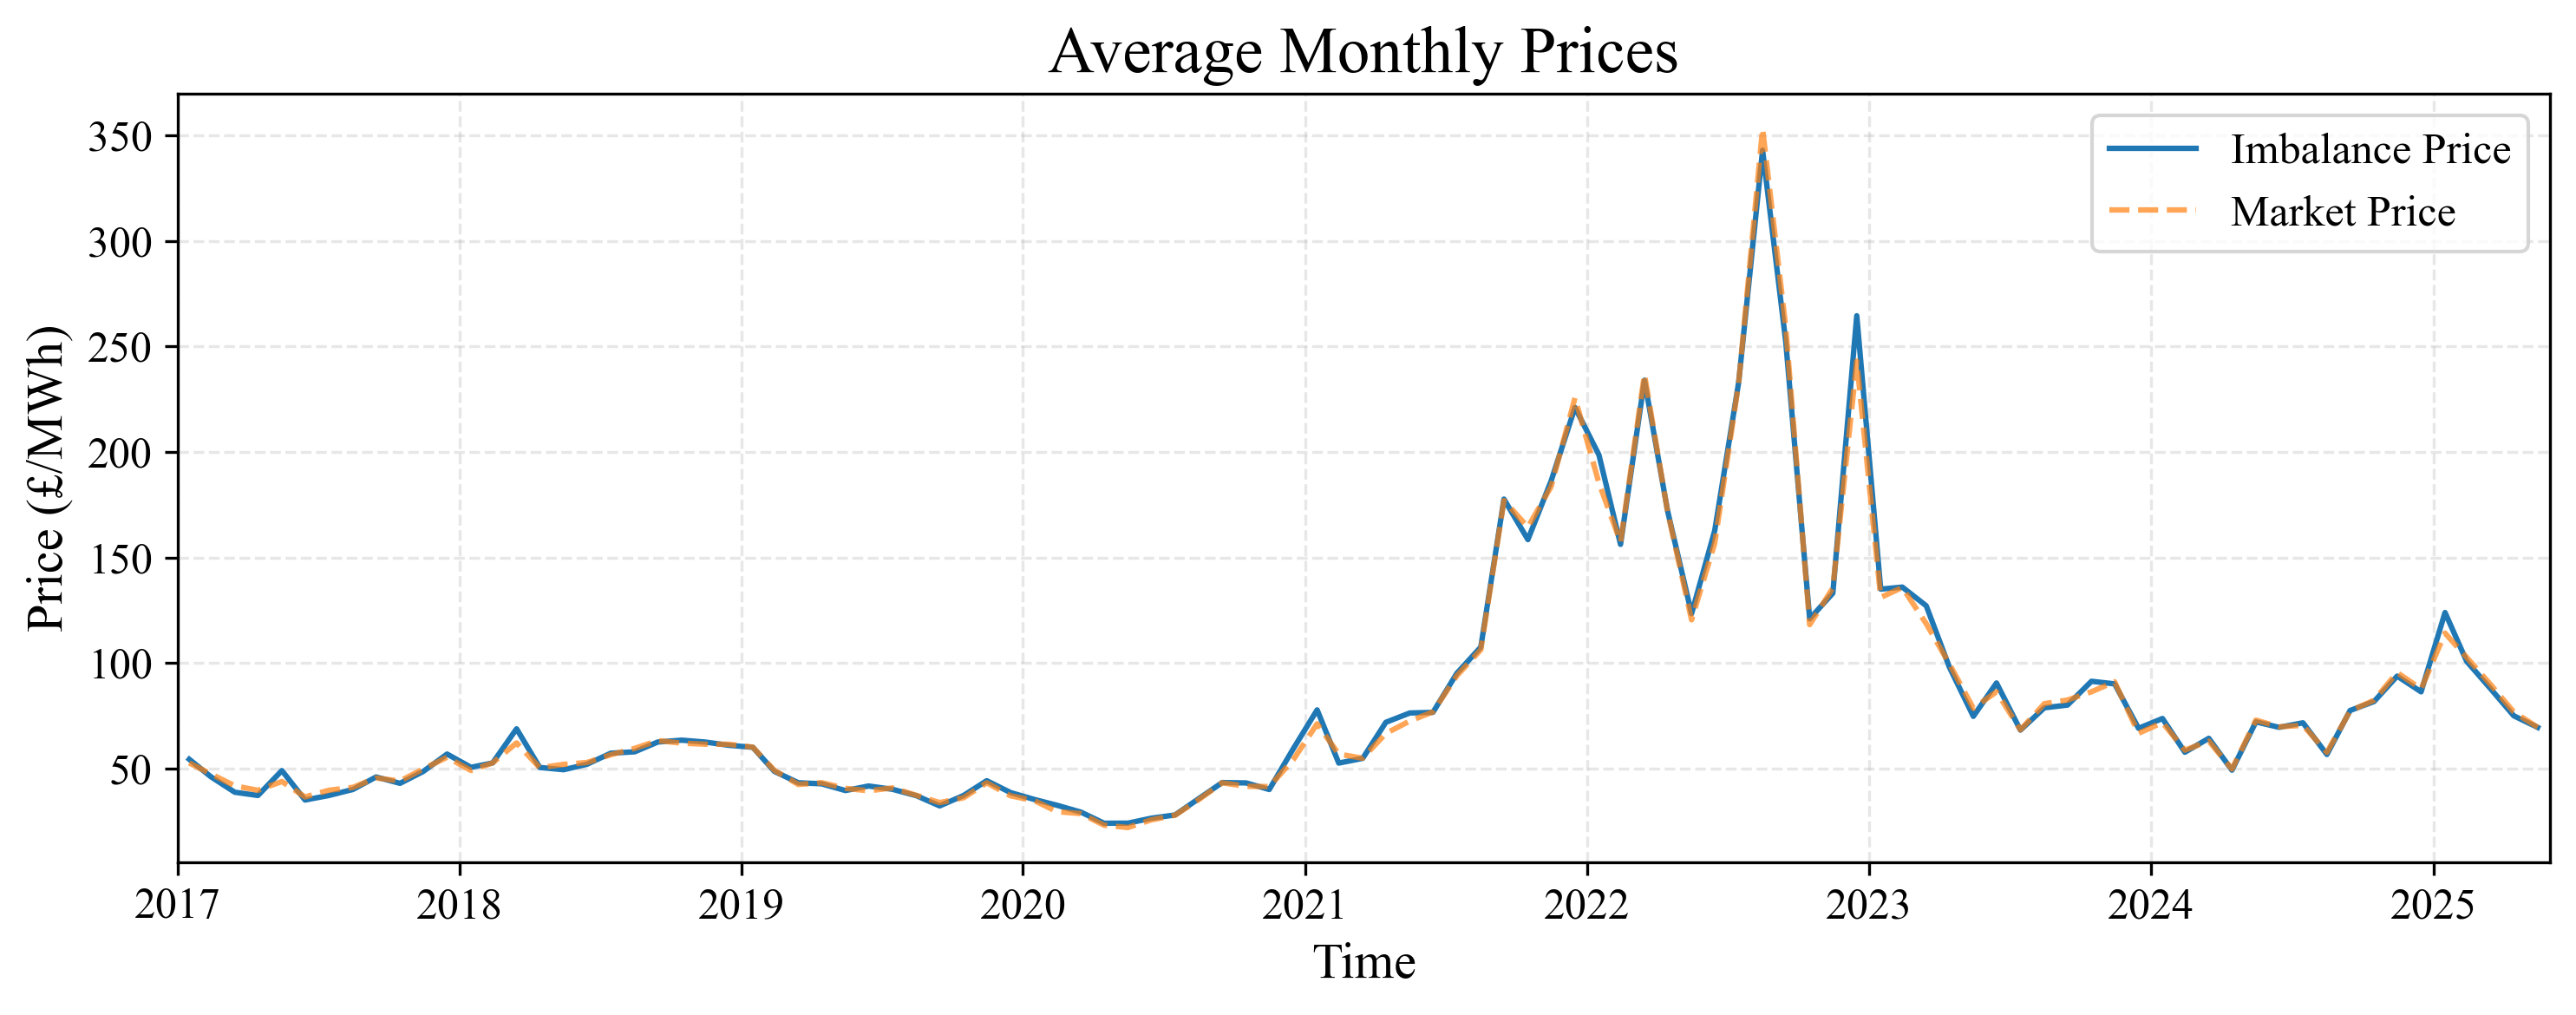

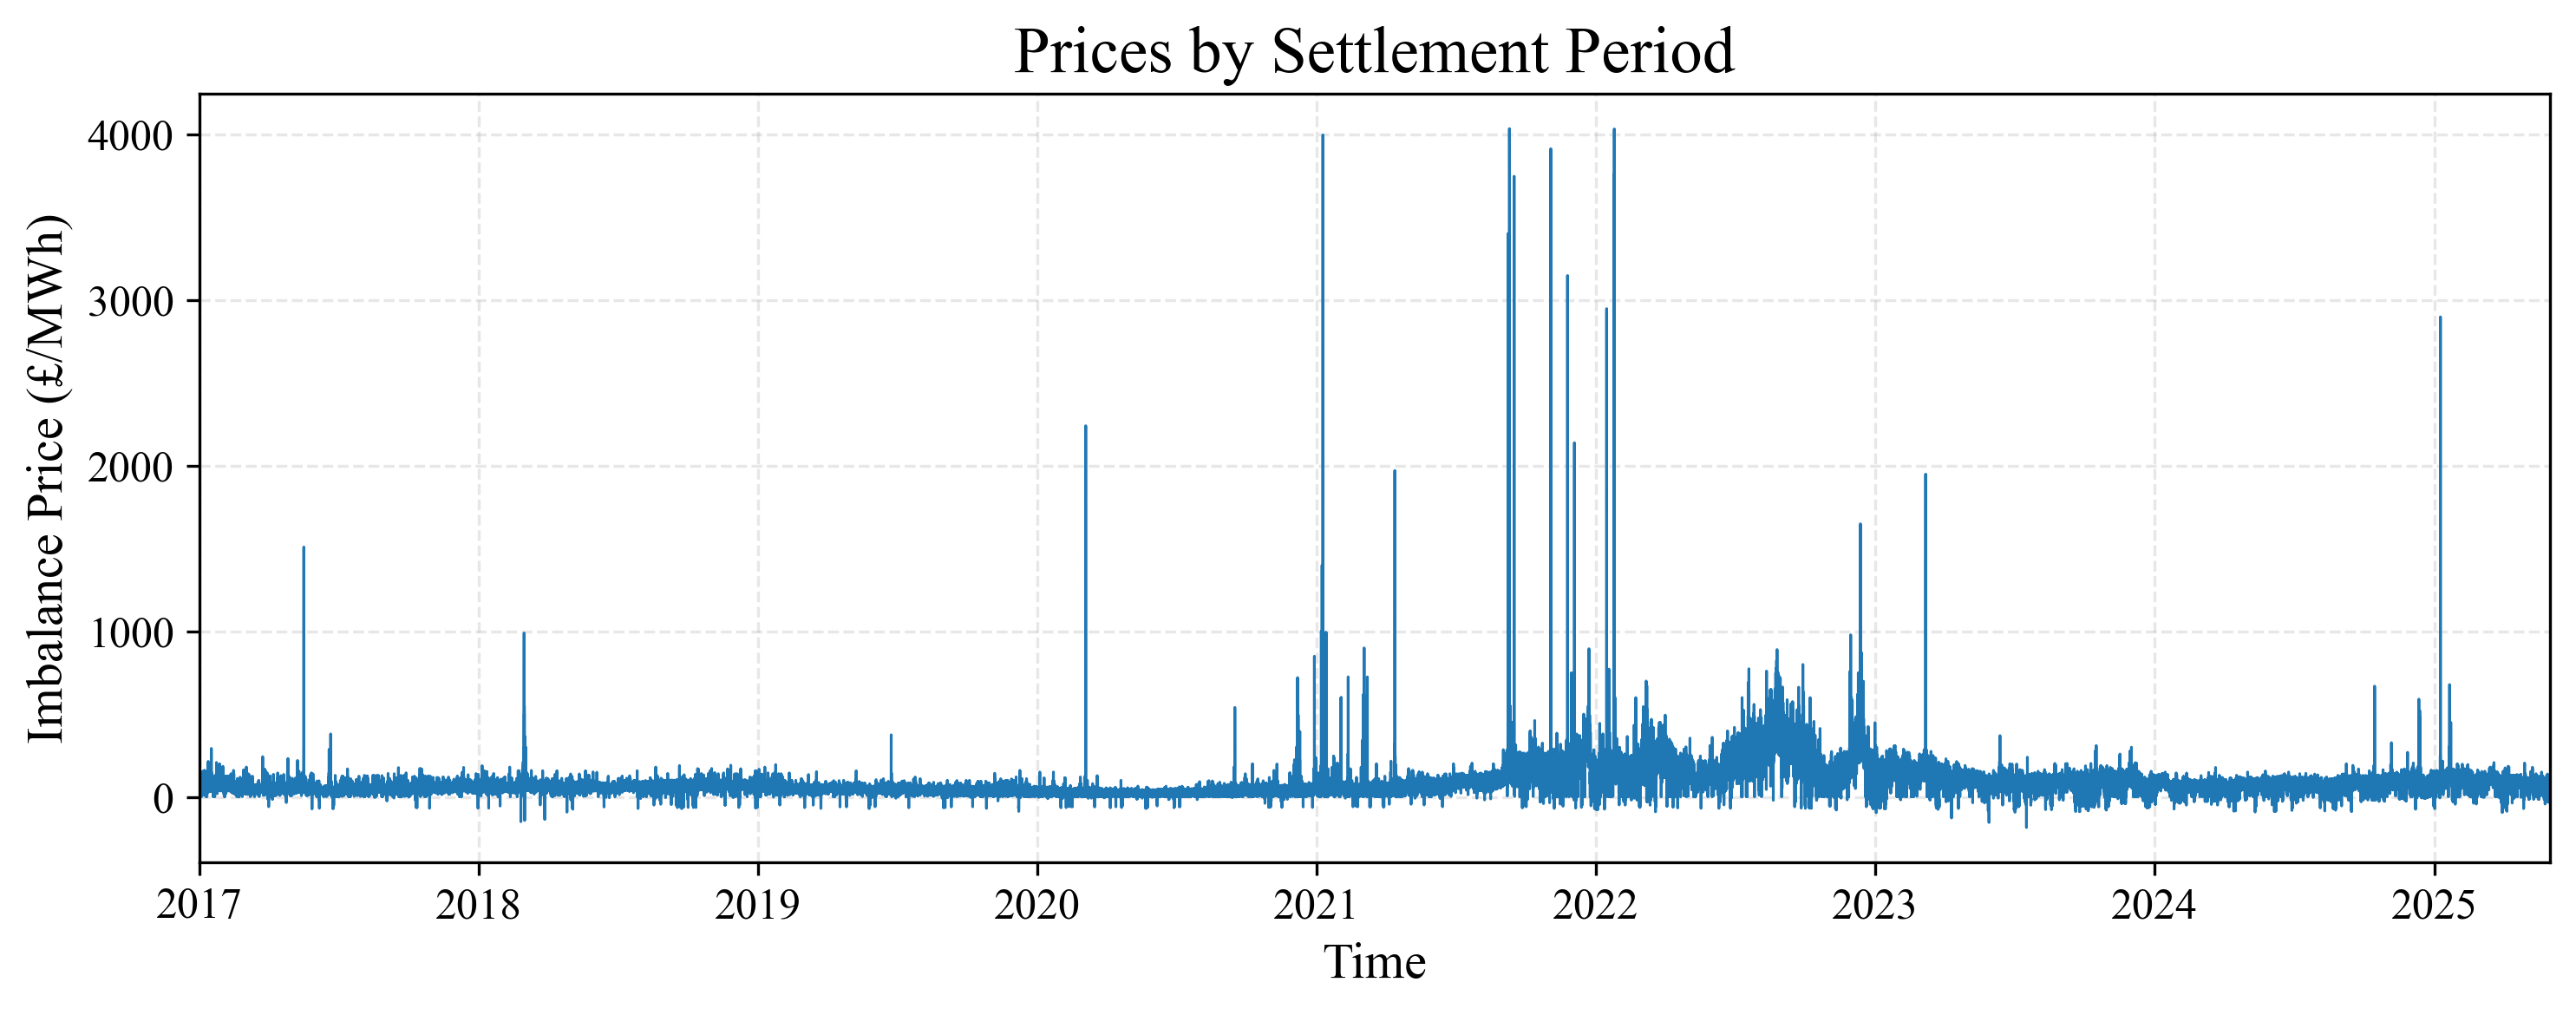

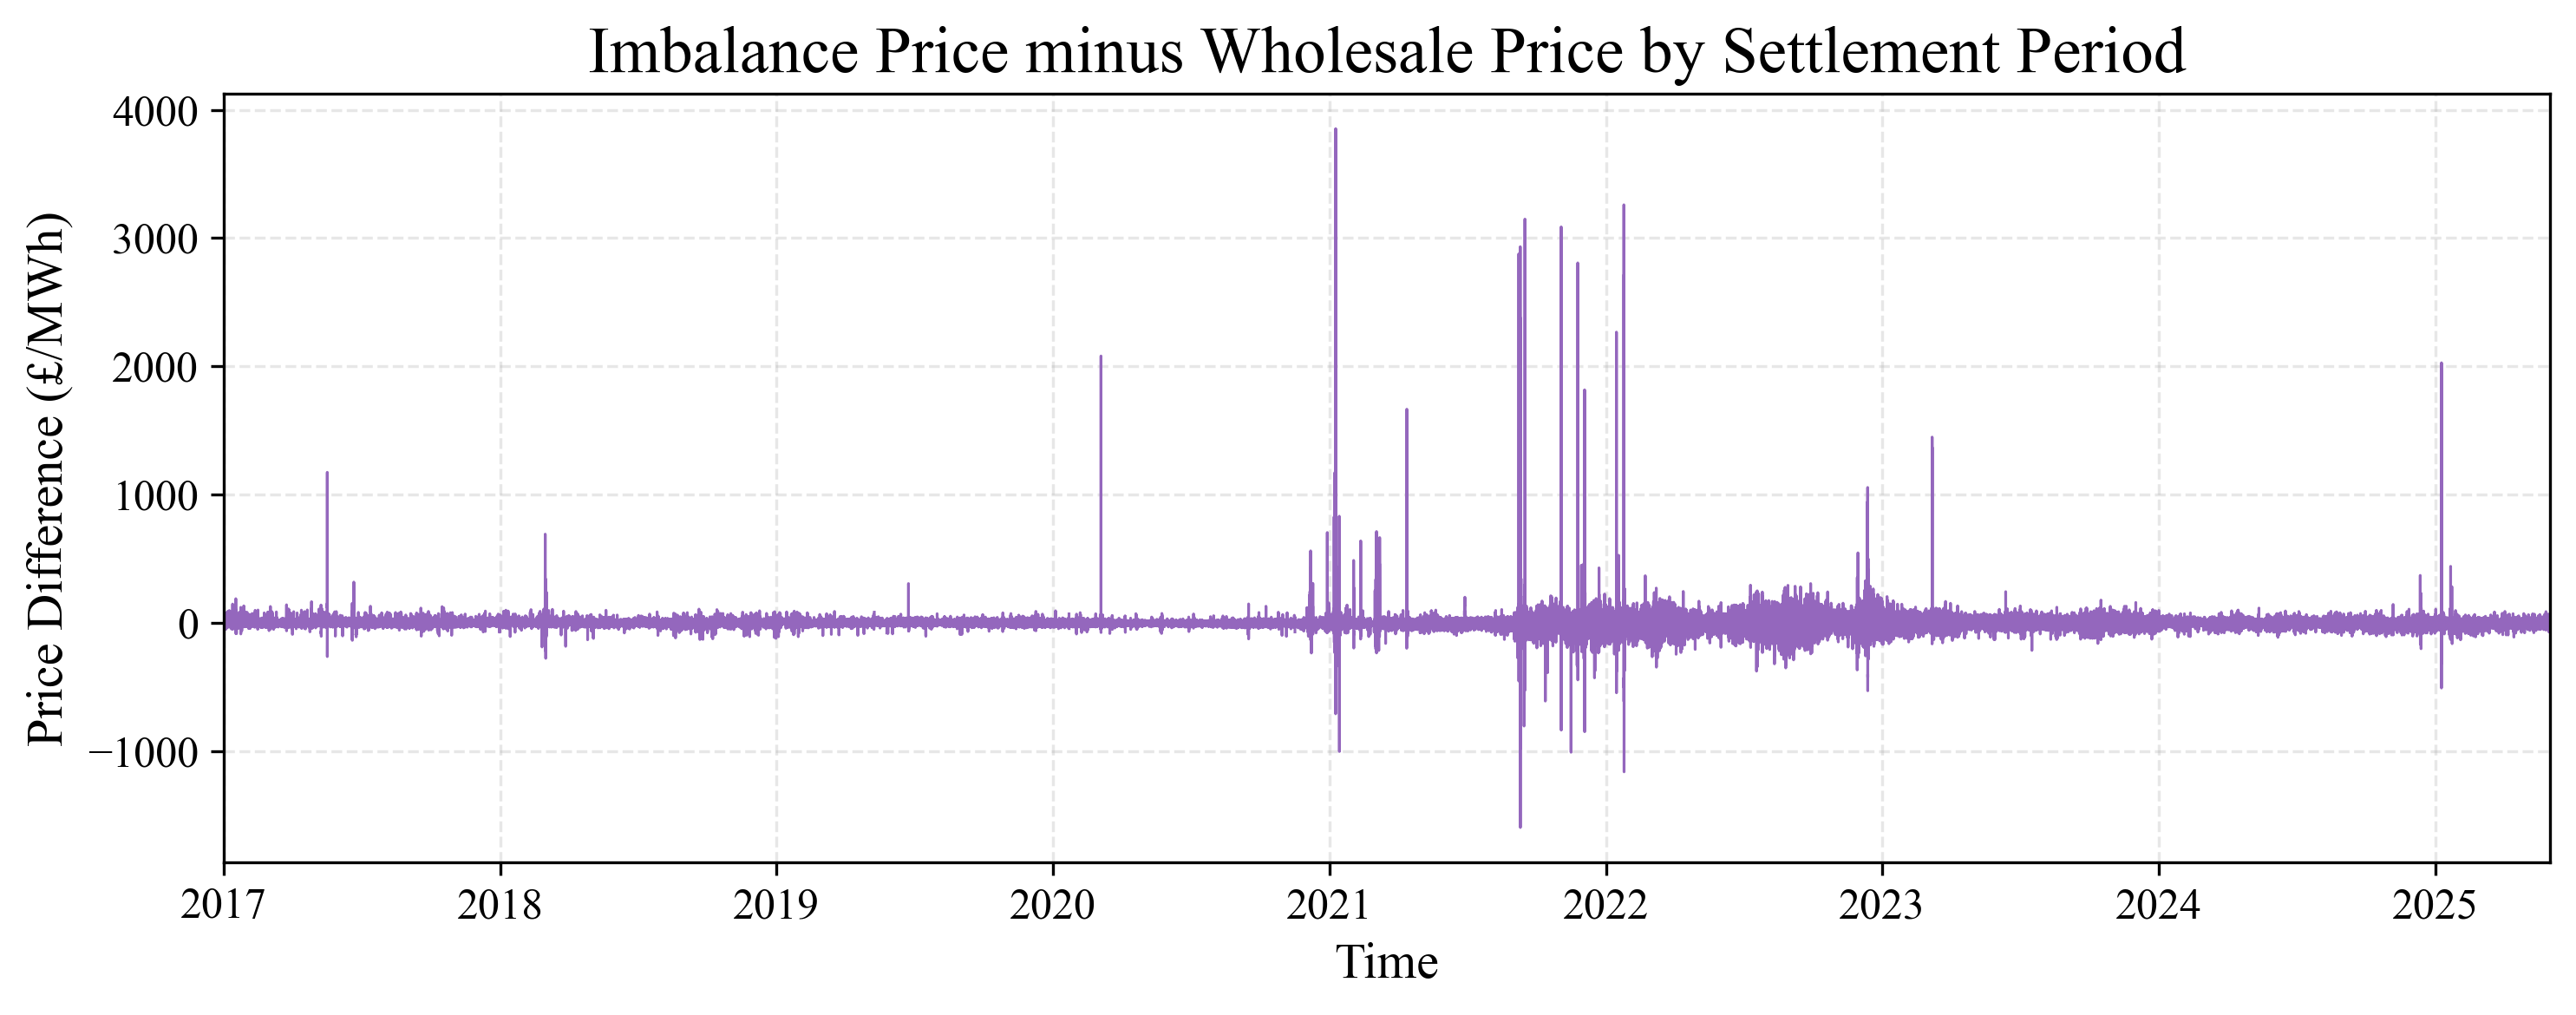

In [56]:
prices_path = CSV_DIR / "SYSTEM_PRICES.csv"
mid_path = CSV_DIR / "MID.csv"

imbalance = pd.read_csv(prices_path, parse_dates=["startTime"])
mid = pd.read_csv(mid_path, parse_dates=["startTime"])

imbalance.set_index("startTime", inplace=True)
mid.set_index("startTime", inplace=True)

price = imbalance["systemPrice"]
wholesale = mid["price"]

diff = price - wholesale

monthly_avg_price = imbalance["systemPrice"].resample("ME").mean().shift(freq='-15D')
monthly_avg_wholesale = mid["price"].resample("ME").mean().shift(freq='-15D')

plt.figure(figsize=(10,4))
plt.plot(monthly_avg_price.index, monthly_avg_price.values, label='Imbalance Price', color='tab:blue')
plt.plot(monthly_avg_wholesale.index, monthly_avg_wholesale.values, label='Market Price', linestyle='--', alpha=.7, color='tab:orange')
plt.title("Average Monthly Prices")
plt.xlabel("Time")
plt.xlim(price.index.min(), price.index.max())
plt.ylabel("Price (£/MWh)")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))
plt.plot(price.index, price.values, linewidth=.75, color='tab:blue', alpha=1)
plt.title("Prices by Settlement Period")
plt.xlabel("Time")
plt.xlim(price.index.min(), price.index.max())
plt.ylabel("Imbalance Price (£/MWh)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(diff.index, diff.values, linewidth=.75, color='tab:purple', alpha=1)
plt.title("Imbalance Price minus Wholesale Price by Settlement Period")
plt.xlabel("Time")
plt.xlim(diff.index.min(), diff.index.max())
plt.ylabel("Price Difference (£/MWh)")
plt.tight_layout()
plt.show()

### Imbalance Price vs. Imbalance Volume

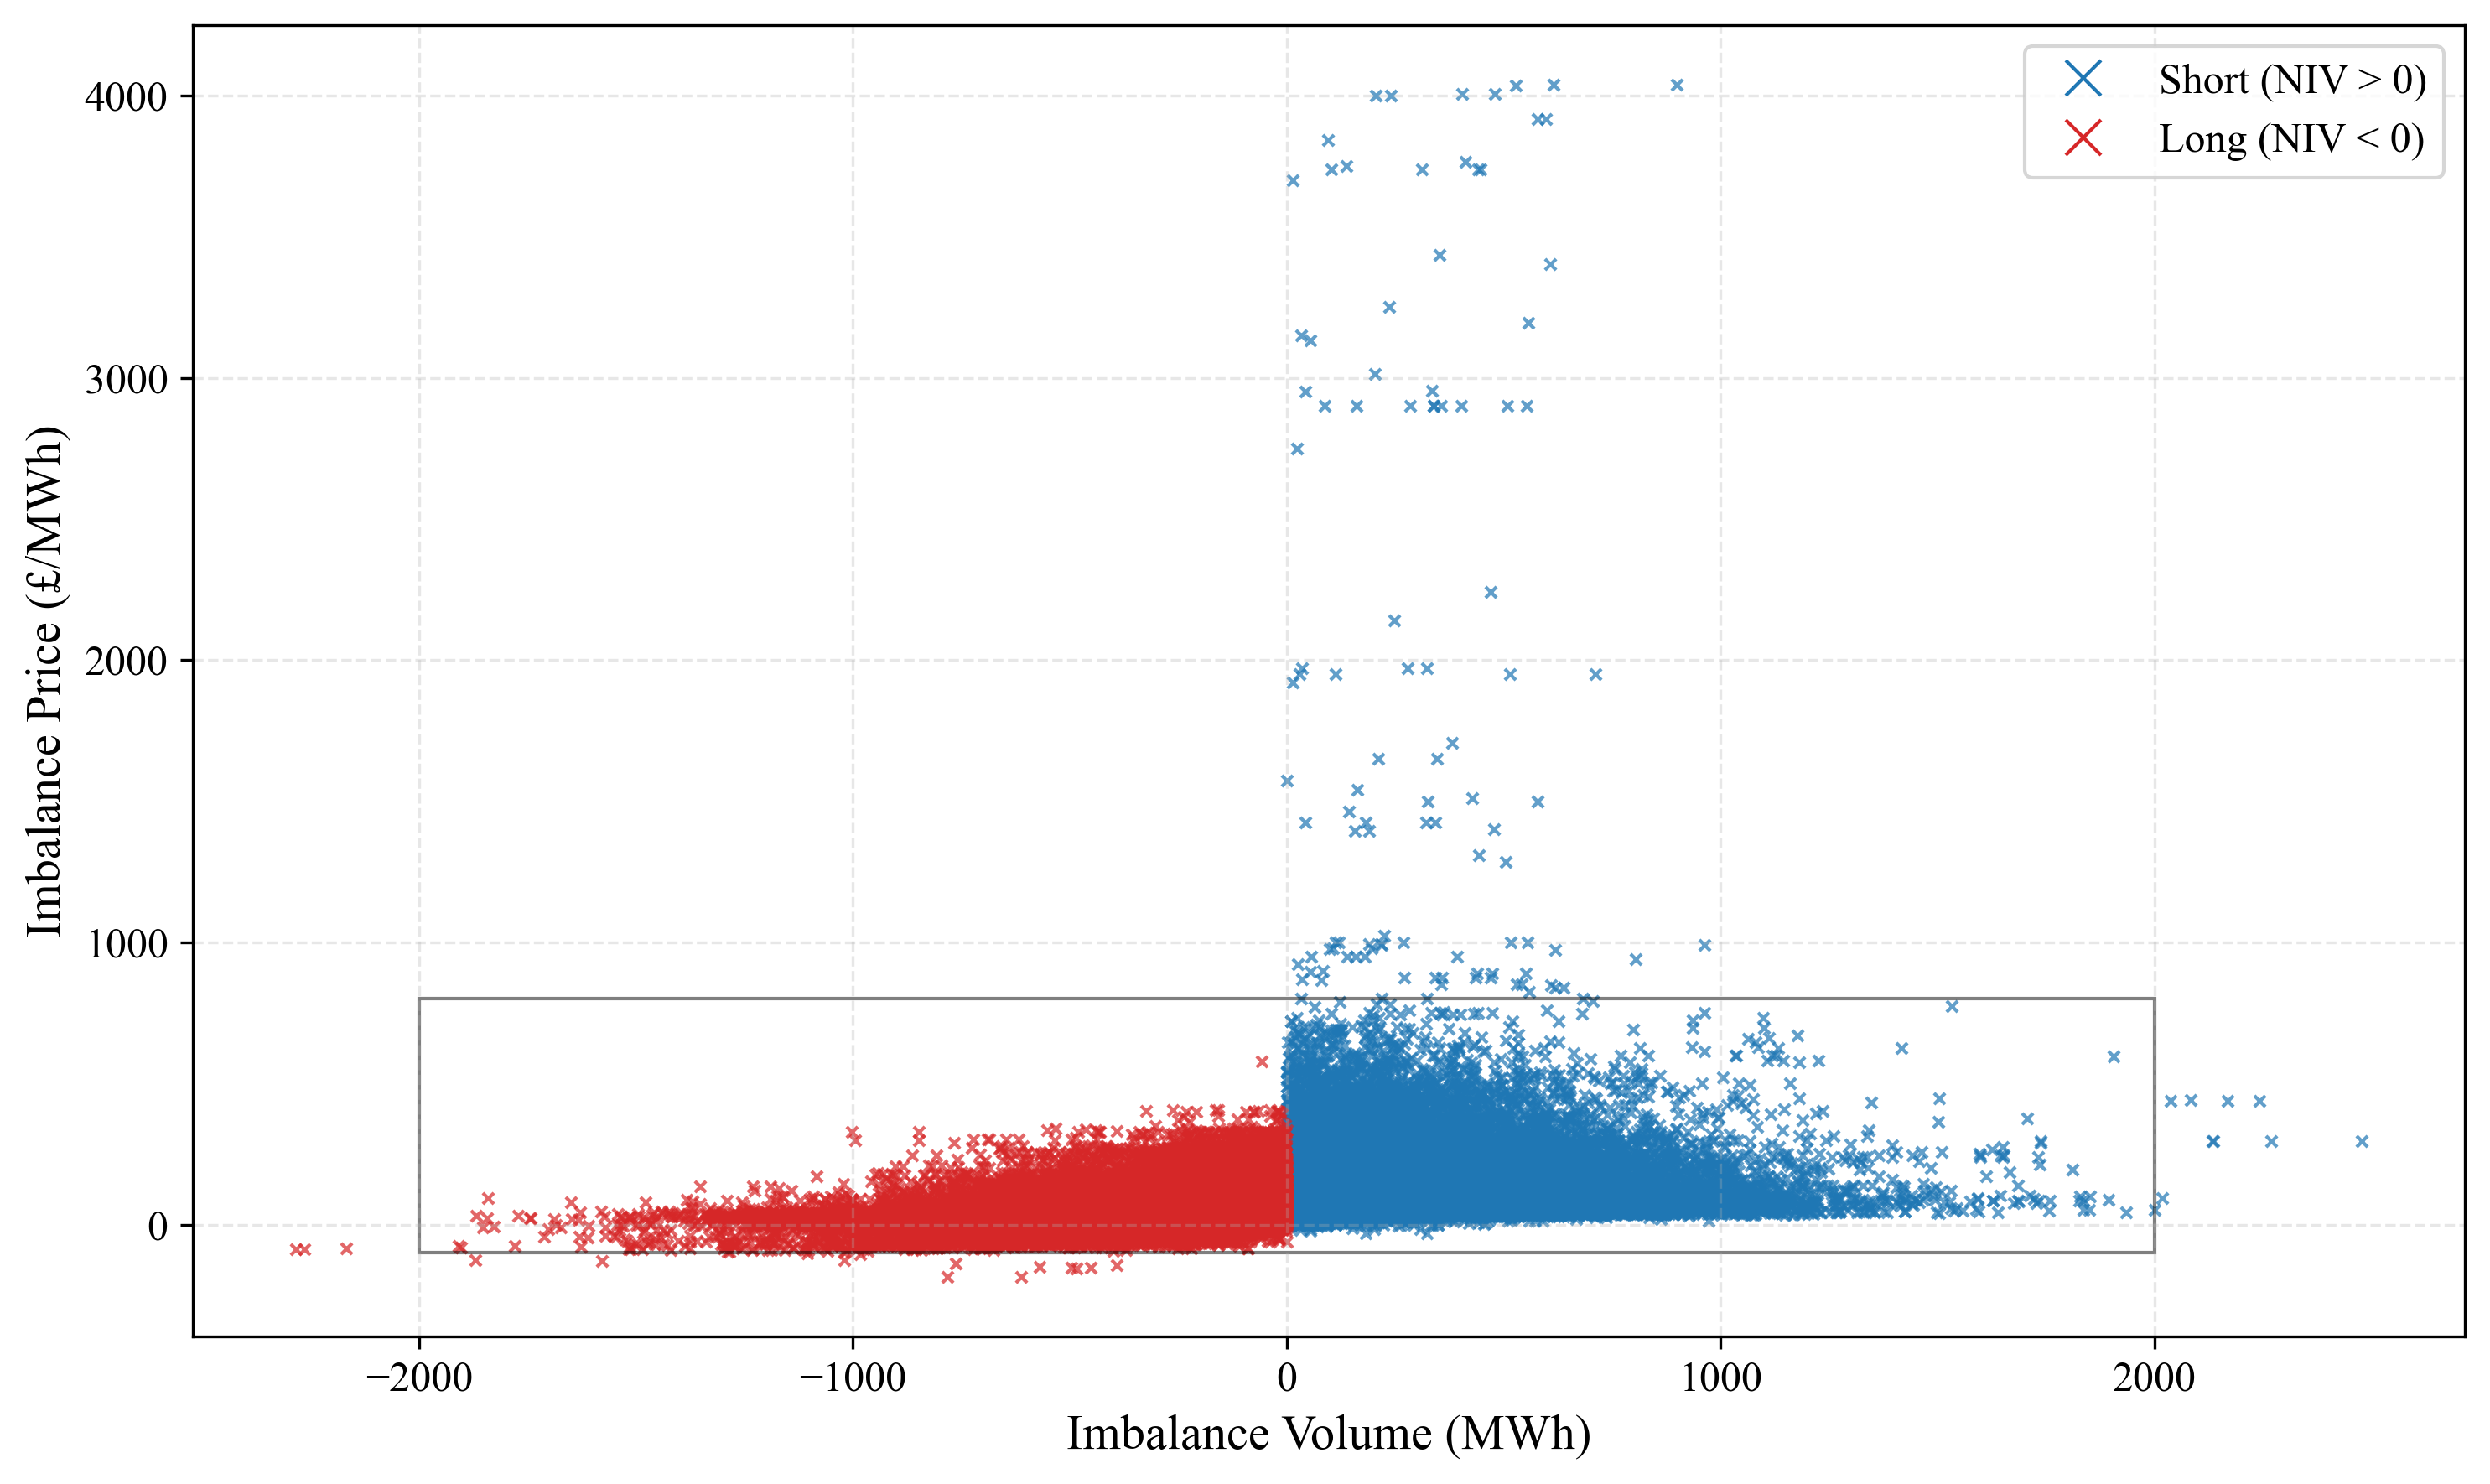

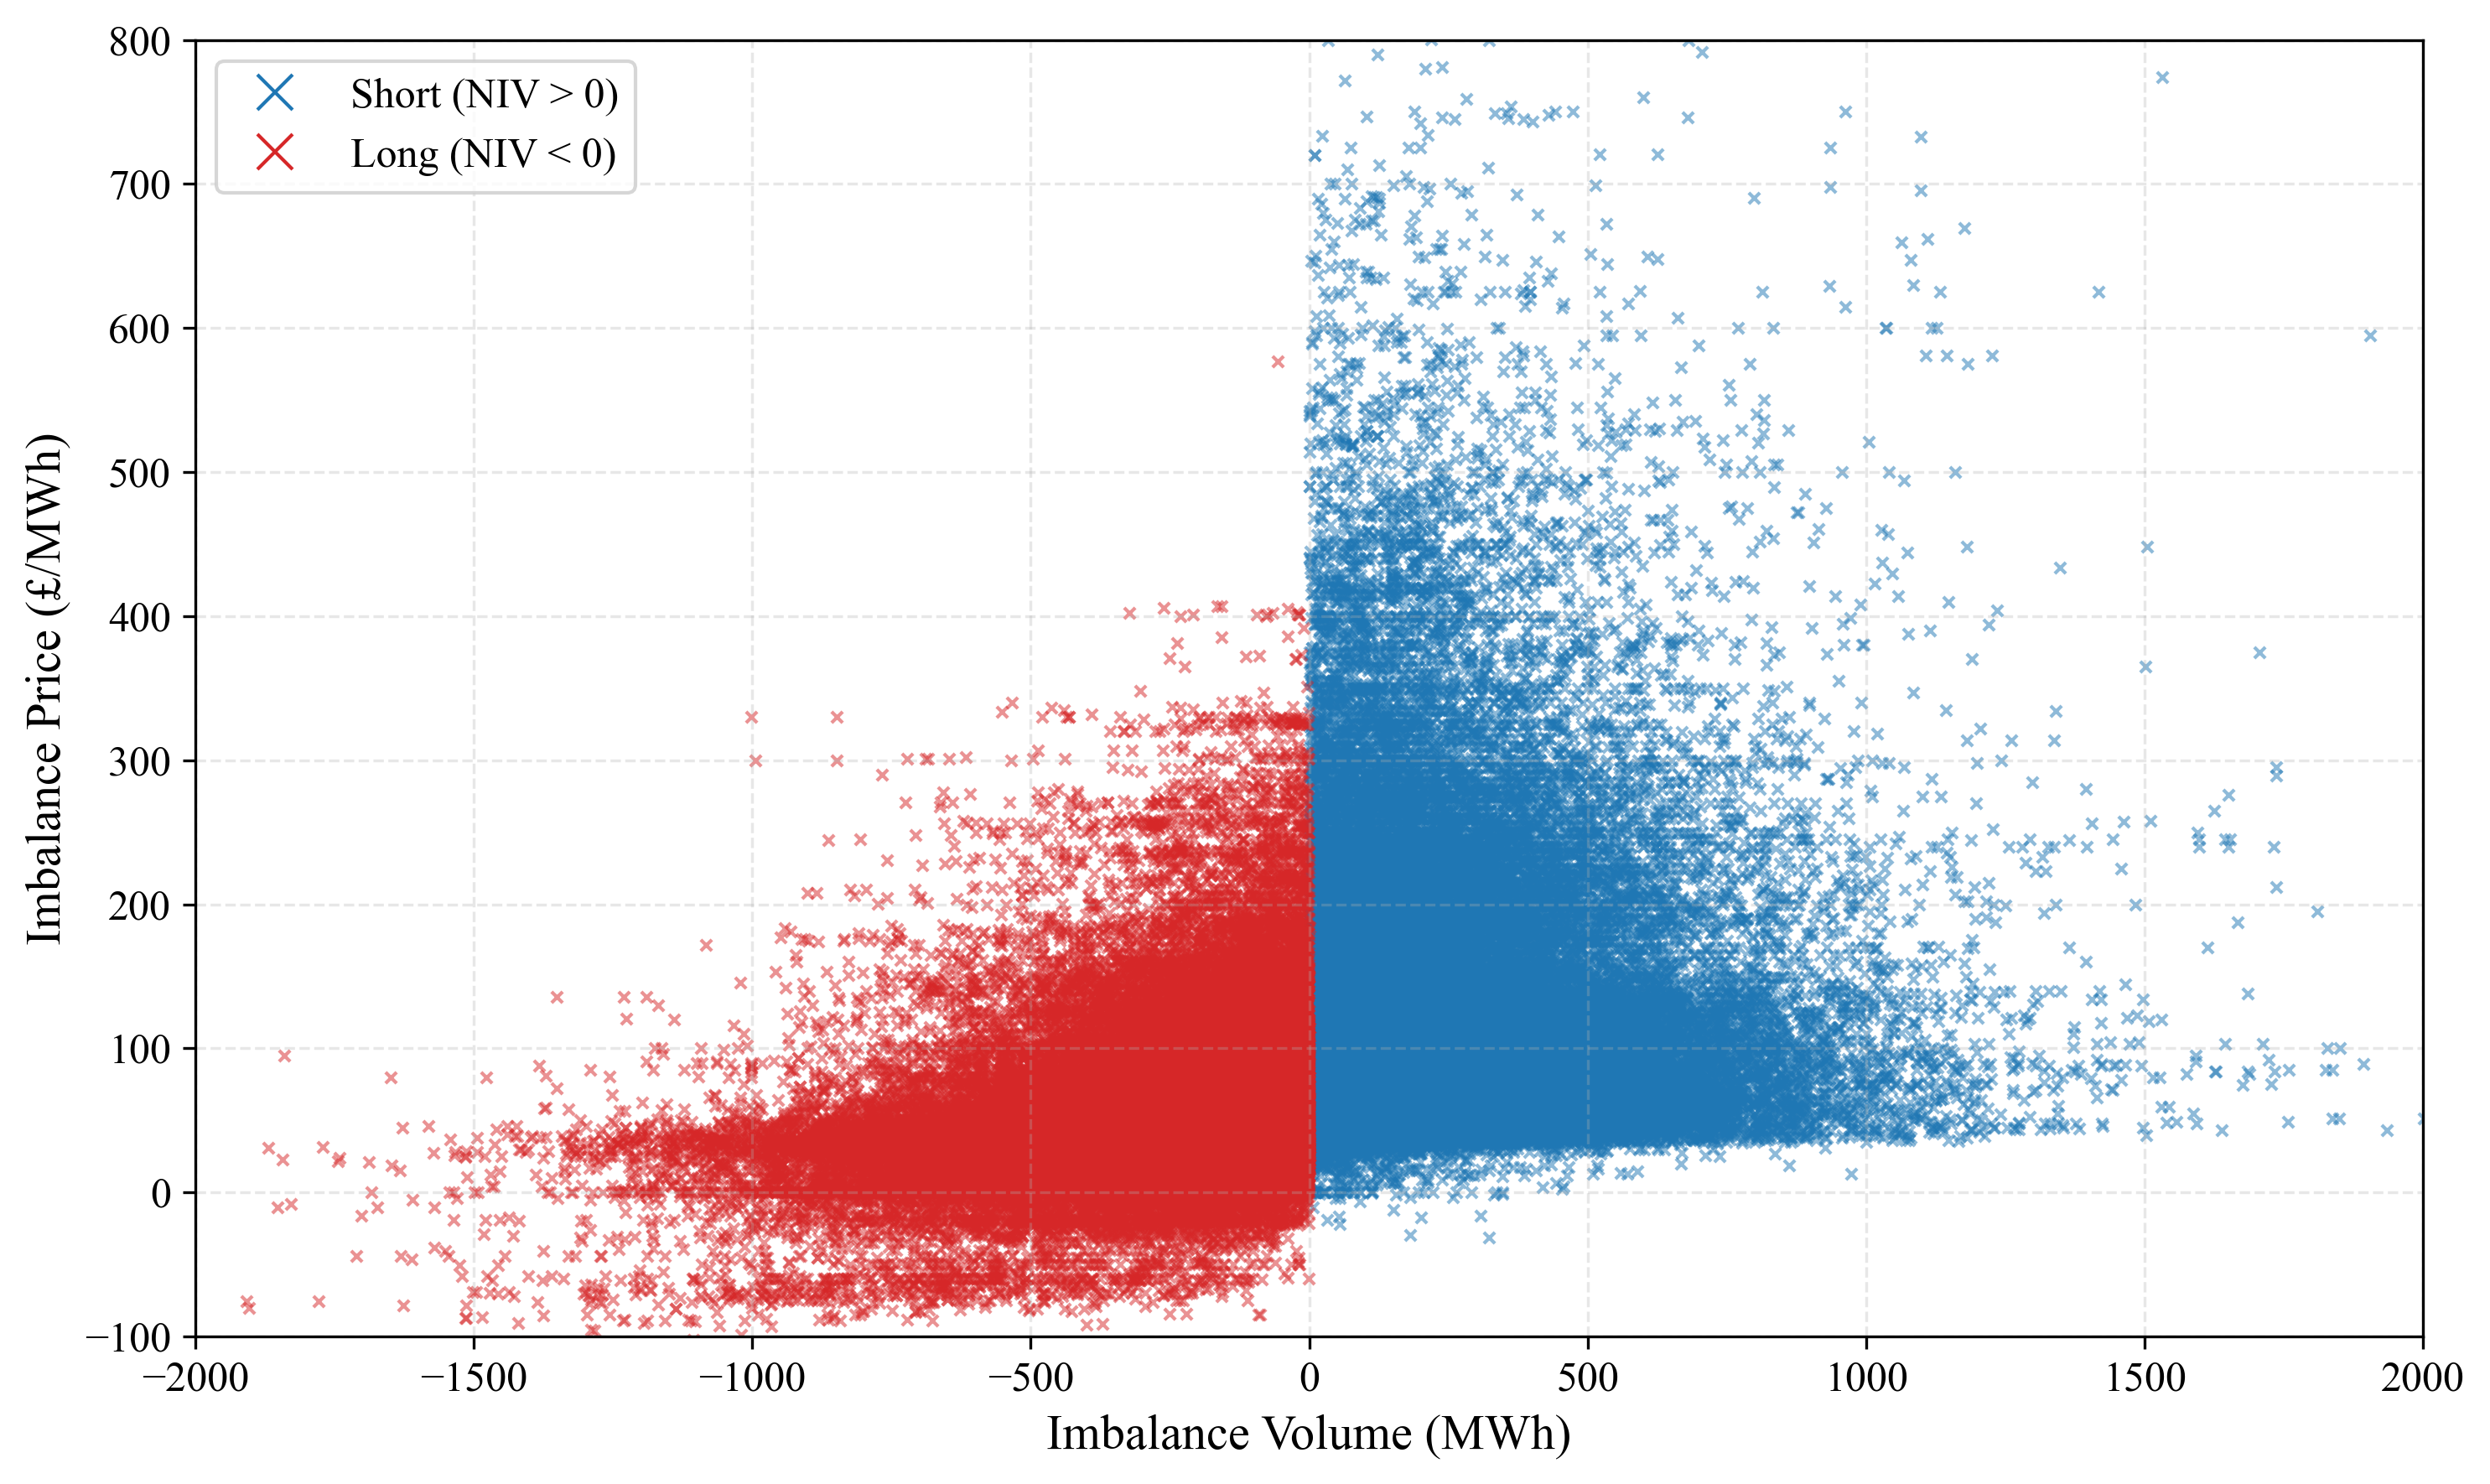

In [81]:
from matplotlib.lines import Line2D

prices_path = CSV_DIR / "SYSTEM_PRICES.csv"
df = pd.read_csv(prices_path, parse_dates=["startTime"])
df.set_index("startTime", inplace=True)

price = df["systemPrice"]
volume = df["netImbalanceVolume"]

neg_mask = volume < 0

# 1) Full scatter with coloured markers
plt.figure(figsize=(10, 6))
plt.scatter(volume[~neg_mask], price[~neg_mask], alpha=0.7, marker='x', s=10, linewidths=1)
plt.scatter(volume[neg_mask],  price[neg_mask],  alpha=0.7, marker='x', s=10, linewidths=1, color='tab:red')

# Custom legend with larger markers
legend_handles = [
    Line2D([0], [0], marker='x', color='tab:blue', markersize=10, linestyle='None', label="Short (NIV > 0)"),
    Line2D([0], [0], marker='x', color='tab:red',  markersize=10, linestyle='None', label="Long (NIV < 0)")
]
plt.legend(handles=legend_handles)

plt.gca().add_patch(
    plt.Rectangle(
        (-2000, -100), 4000, 900,
        fill=False, edgecolor="black", linewidth=1, alpha=0.5
    )
)
plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.tight_layout()
plt.show()

# 2) Zoomed-in version
plt.figure(figsize=(10, 6))
plt.scatter(volume[~neg_mask], price[~neg_mask], alpha=0.5, marker='x', s=10, linewidths=1)
plt.scatter(volume[neg_mask],  price[neg_mask],  alpha=0.5, marker='x', s=10, linewidths=1, color='tab:red')

# Reuse the same custom legend
plt.legend(handles=legend_handles)

plt.ylabel("Imbalance Price (£/MWh)")
plt.xlabel("Imbalance Volume (MWh)")
plt.xlim(-2000, 2000)
plt.ylim(-100, 800)
plt.tight_layout()
plt.show()


### Day-Ahead Forecast vs Actual

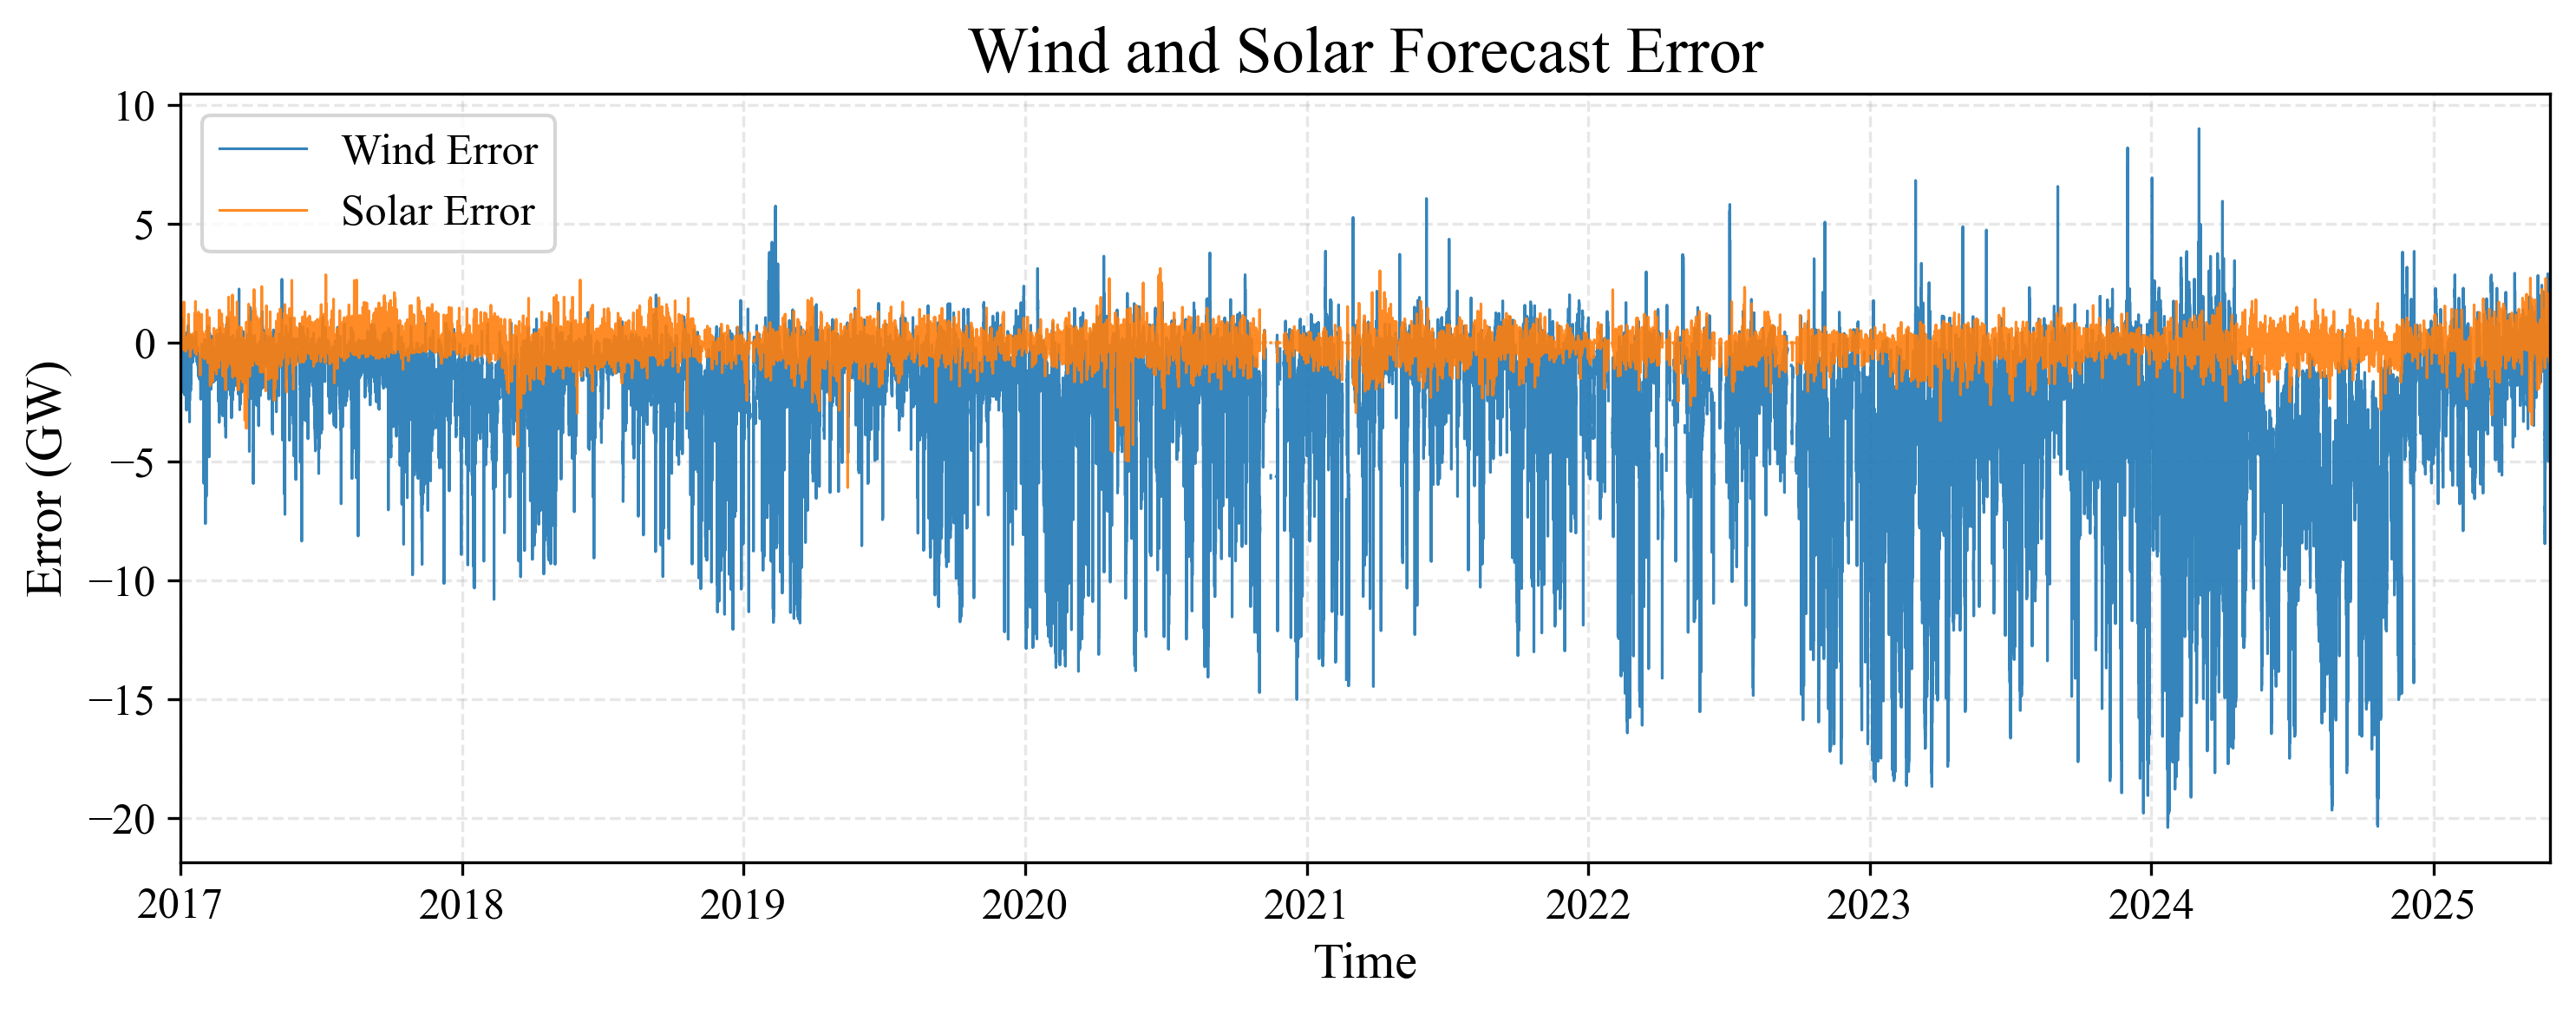

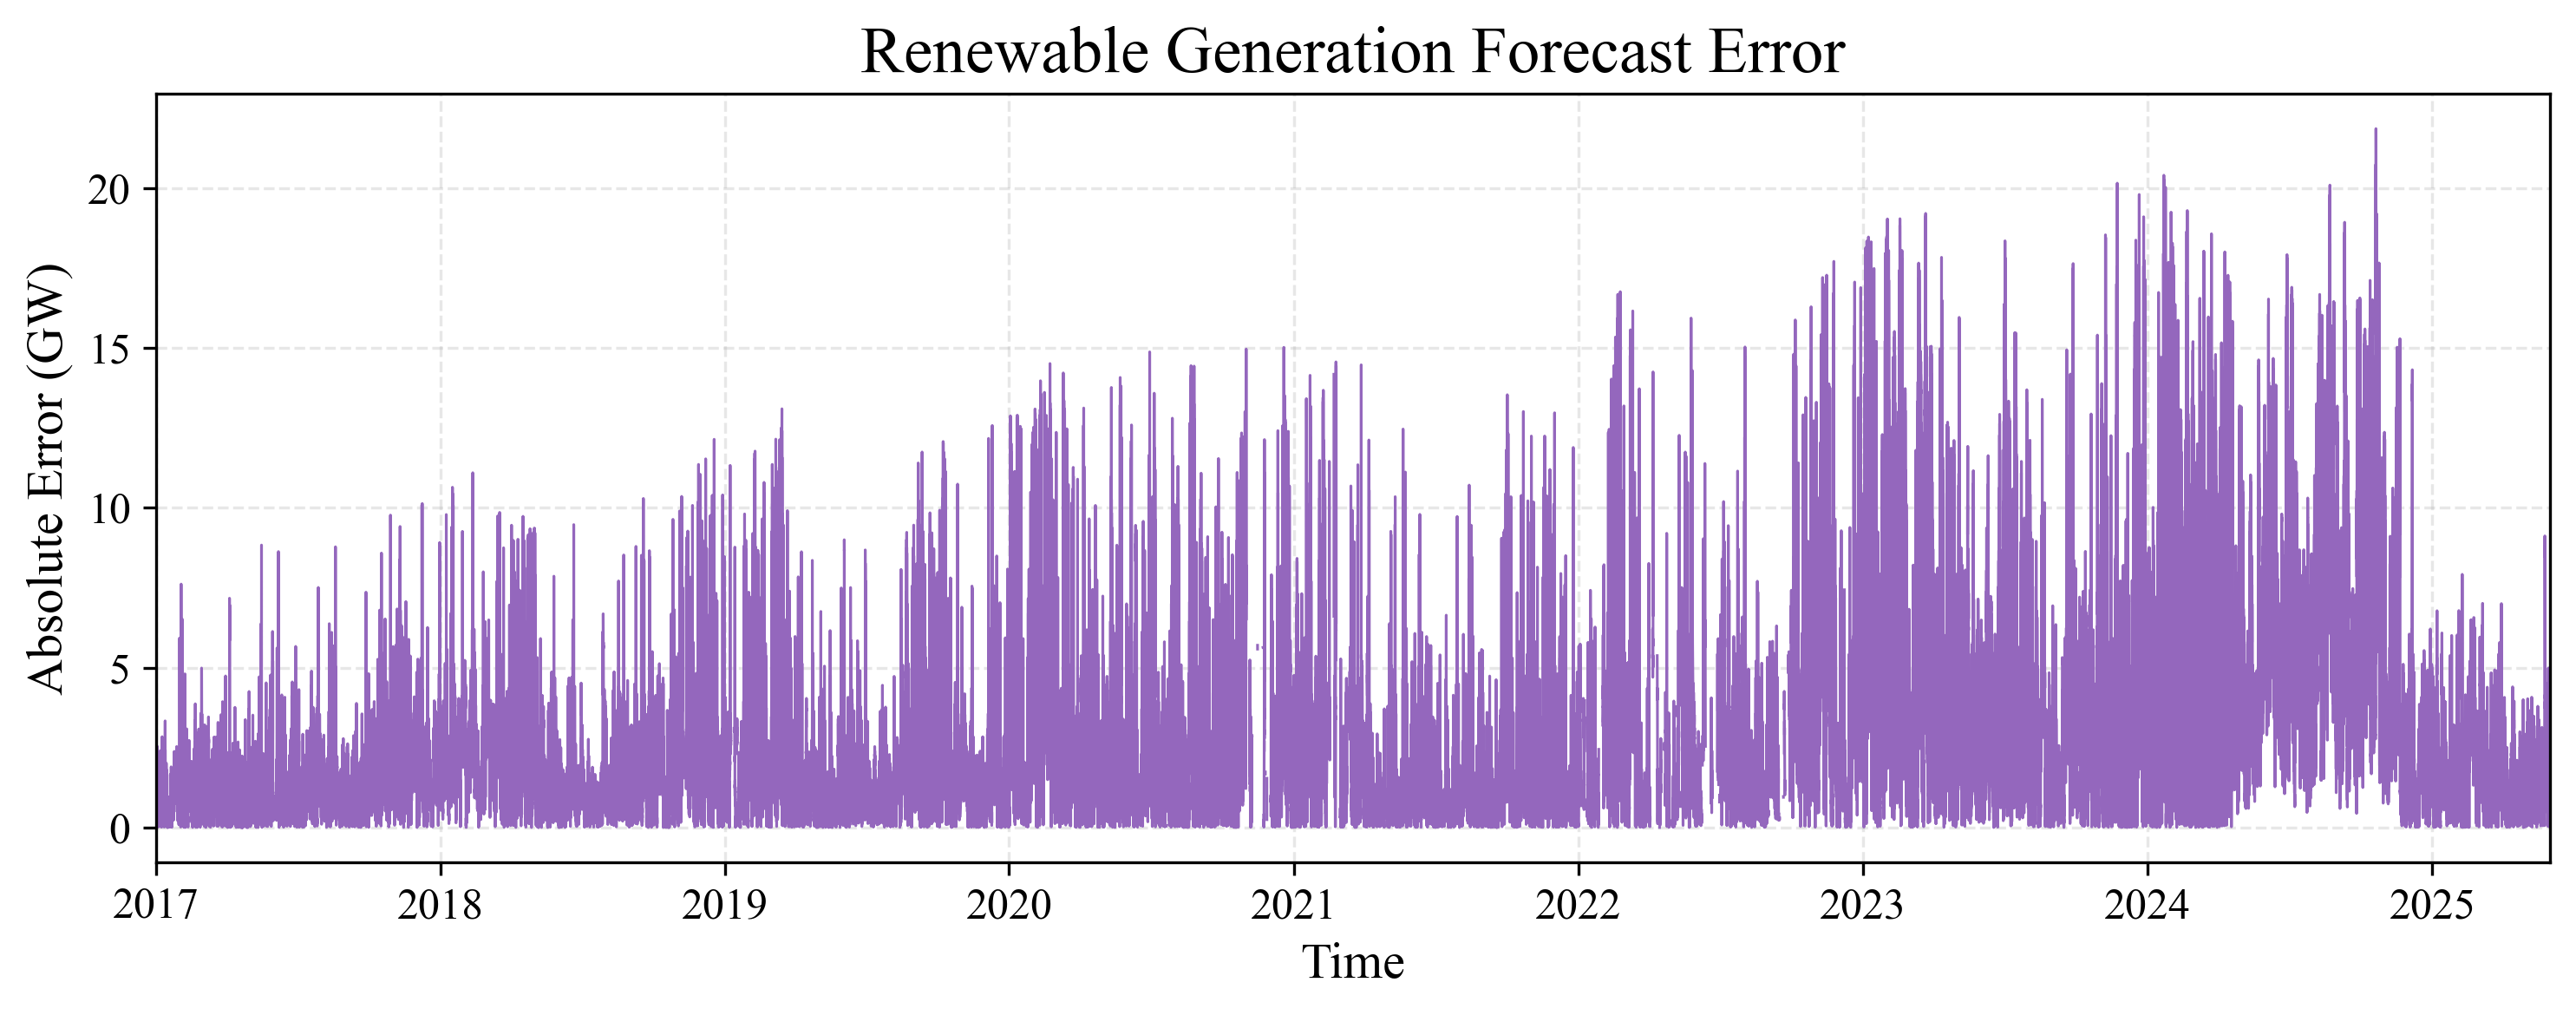

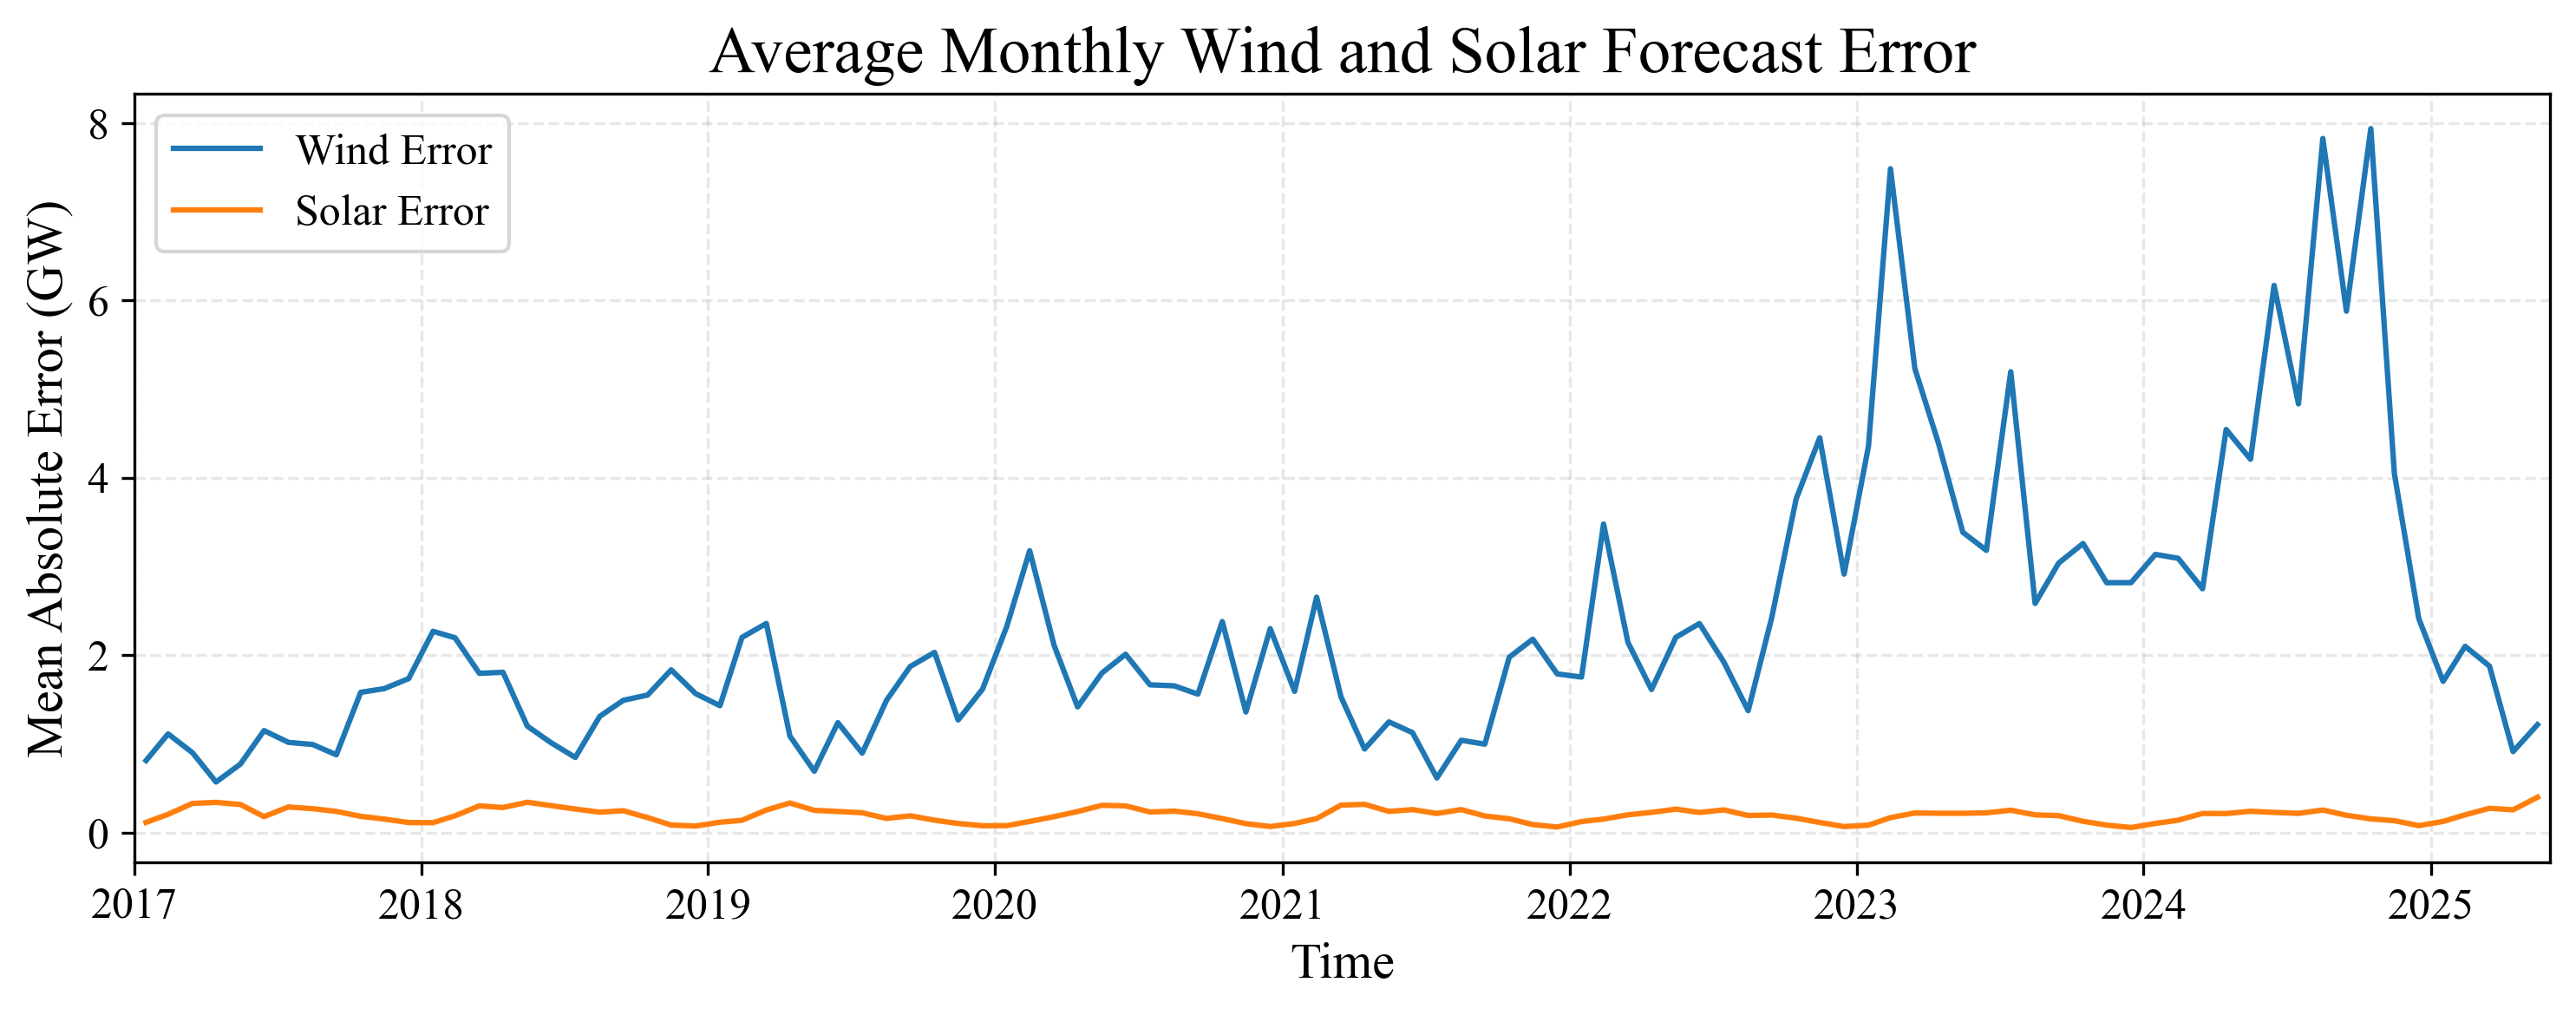

In [106]:
agws_path = CSV_DIR / "ACTUAL_GEN_WIND_SOLAR.csv"
dgws_path = CSV_DIR / "DAYAHEAD_GEN_WIND_SOLAR.csv"

agws = pd.read_csv(agws_path, parse_dates=["startTime"]).set_index("startTime")
dgws = pd.read_csv(dgws_path, parse_dates=["startTime"]).set_index("startTime")

agws["totalWind"] = agws["windOnshoreGeneration"] + agws["windOffshoreGeneration"]
dgws["totalWind"] = dgws["windOnshoreGeneration"] + dgws["windOffshoreGeneration"]

# Force NaN for missing values
wind_df = pd.concat([
    agws["totalWind"],
    dgws["totalWind"]
], axis=1, keys=["act", "fc"])

solar_df = pd.concat([
    agws["solarGeneration"],
    dgws["solarGeneration"]
], axis=1, keys=["act", "fc"])

# Errors in MW
wind_error = (wind_df["act"] - wind_df["fc"])
solar_error = (solar_df["act"] - solar_df["fc"])

wind_error_abs = (wind_df["act"] - wind_df["fc"]).abs()
solar_error_abs = (solar_df["act"] - solar_df["fc"]).abs()

# Convert to GW
wind_error_gw  = wind_error  / 1_000
solar_error_gw = solar_error / 1_000
total_error_abs_gw = (wind_error_abs + solar_error_abs) / 1_000

# Resample and shift timestamps to month centres
monthly_wind_error_gw  = wind_error_abs.resample("ME").mean().shift(freq='-15D') / 1_000
monthly_solar_error_gw = solar_error_abs.resample("ME").mean().shift(freq='-15D') / 1_000


#1) Wind & Solar error time series in GW
plt.figure(figsize=(10, 4))
plt.plot(wind_error_gw.index,  wind_error_gw.values,  label="Wind Error", linewidth=0.75, alpha=0.9)
plt.plot(solar_error_gw.index, solar_error_gw.values, label="Solar Error", linewidth=0.75, alpha=0.9)
plt.title("Wind and Solar Forecast Error")
plt.xlabel("Time")
plt.ylabel("Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(0, max(wind_error.max(), solar_error.max()) / 1_000 * 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Total forecast error in GW
plt.figure(figsize=(10, 4))
plt.plot(total_error_abs_gw.index, total_error_abs_gw.values, color='tab:purple', linewidth=0.75)
plt.title("Renewable Generation Forecast Error")
plt.xlabel("Time")
plt.ylabel("Absolute Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(0, total_error_gw.max() * 1.05)
plt.tight_layout()
plt.show()

# 3) Average monthly error in GW
plt.figure(figsize=(10, 4))
plt.plot(monthly_wind_error_gw.index,  monthly_wind_error_gw.values,  label="Wind Error")
plt.plot(monthly_solar_error_gw.index, monthly_solar_error_gw.values, label="Solar Error")
plt.title("Average Monthly Wind and Solar Forecast Error")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Error (GW)")
plt.xlim(wind_error.index.min(), wind_error.index.max())
#plt.ylim(monthly_wind_error_gw.min() * 1.05, monthly_solar_error_gw.max() * 1.05)
plt.legend()
plt.tight_layout()
plt.show()


### Demand Forecast Error

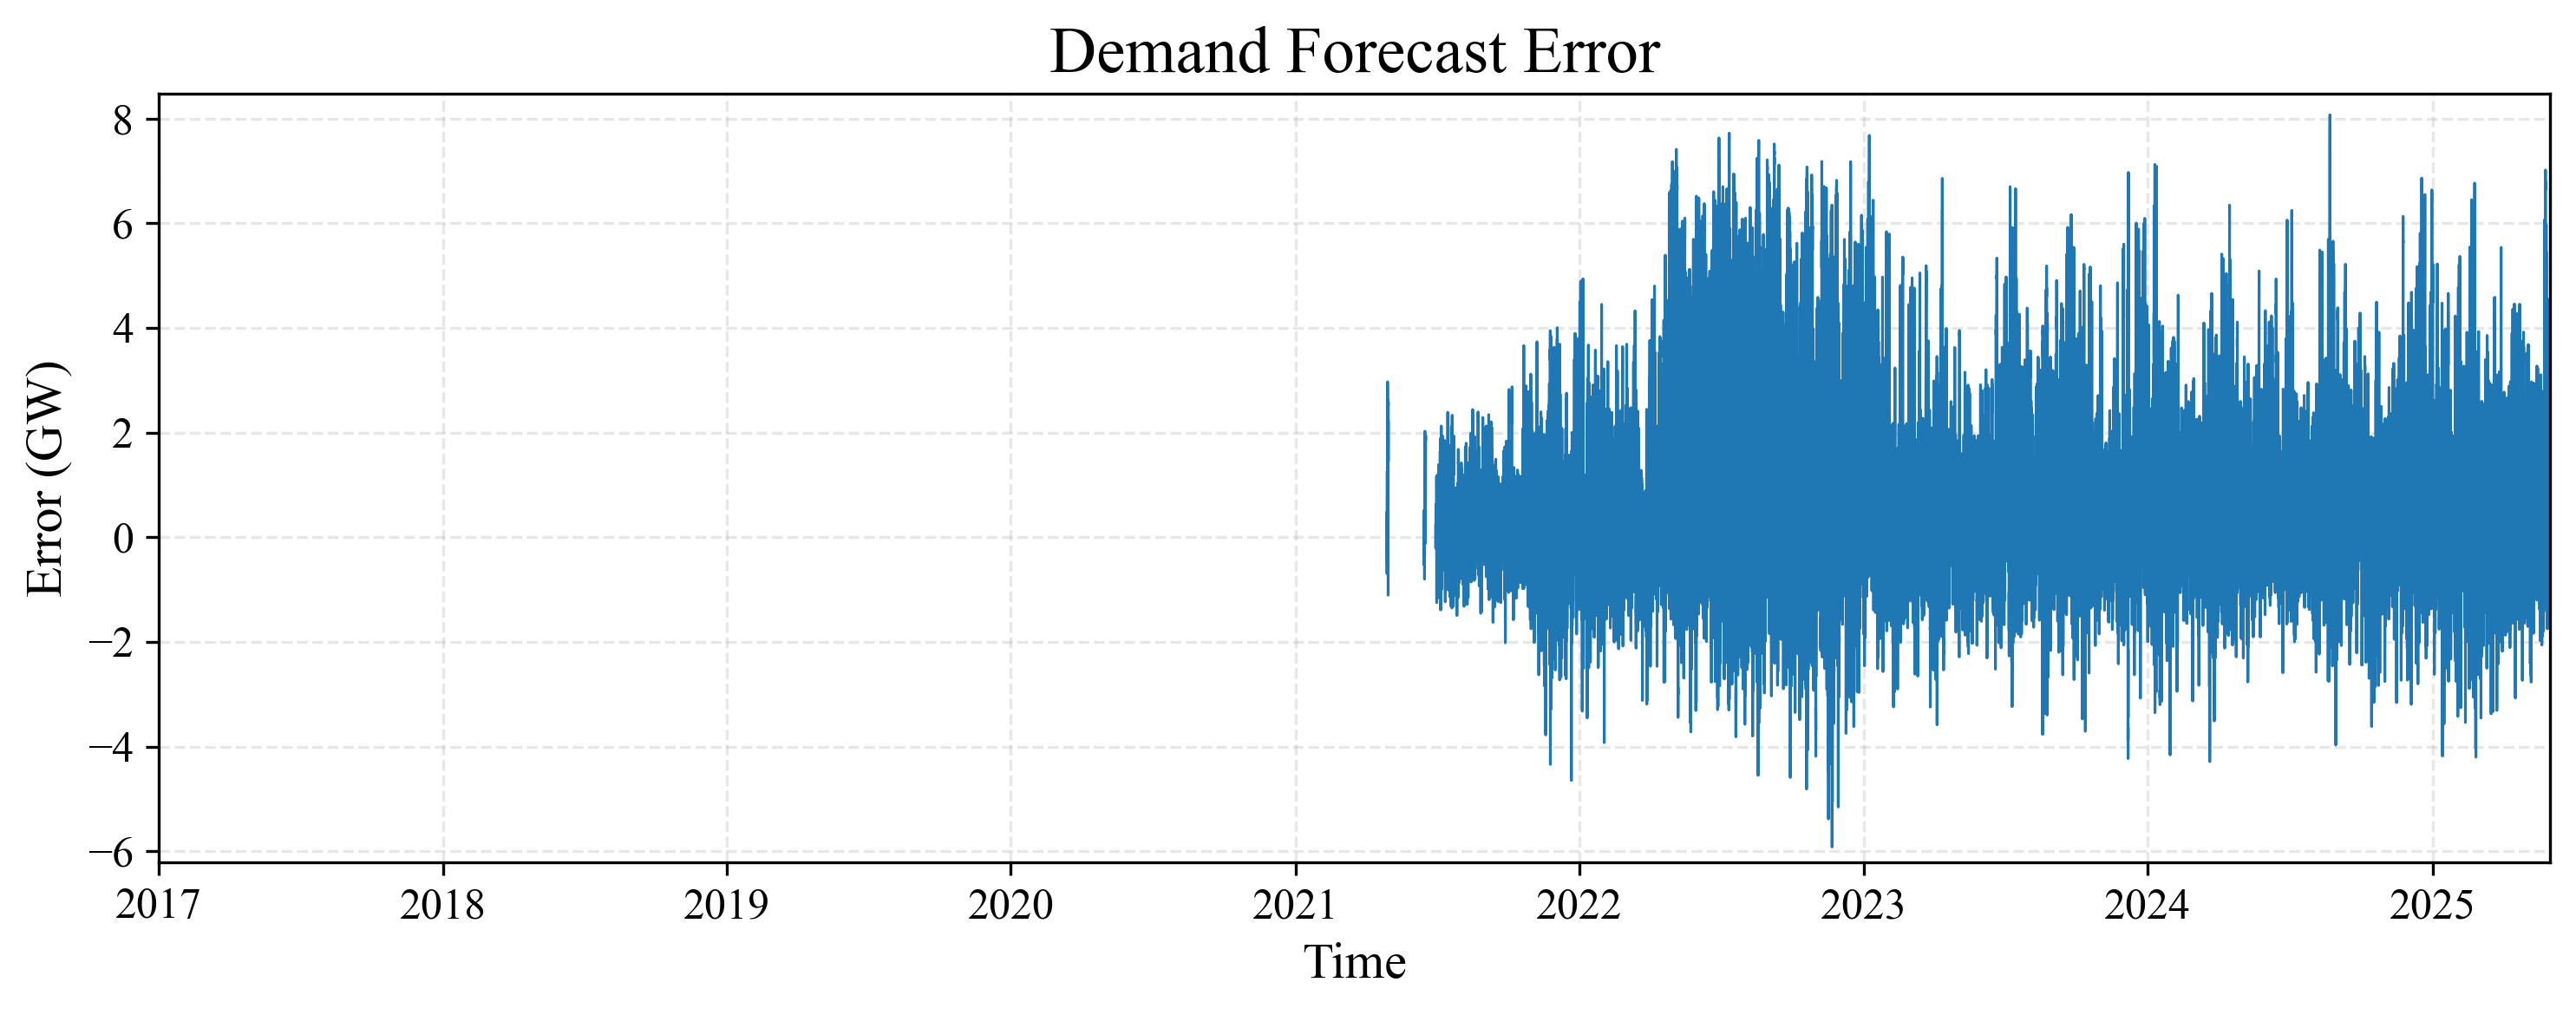

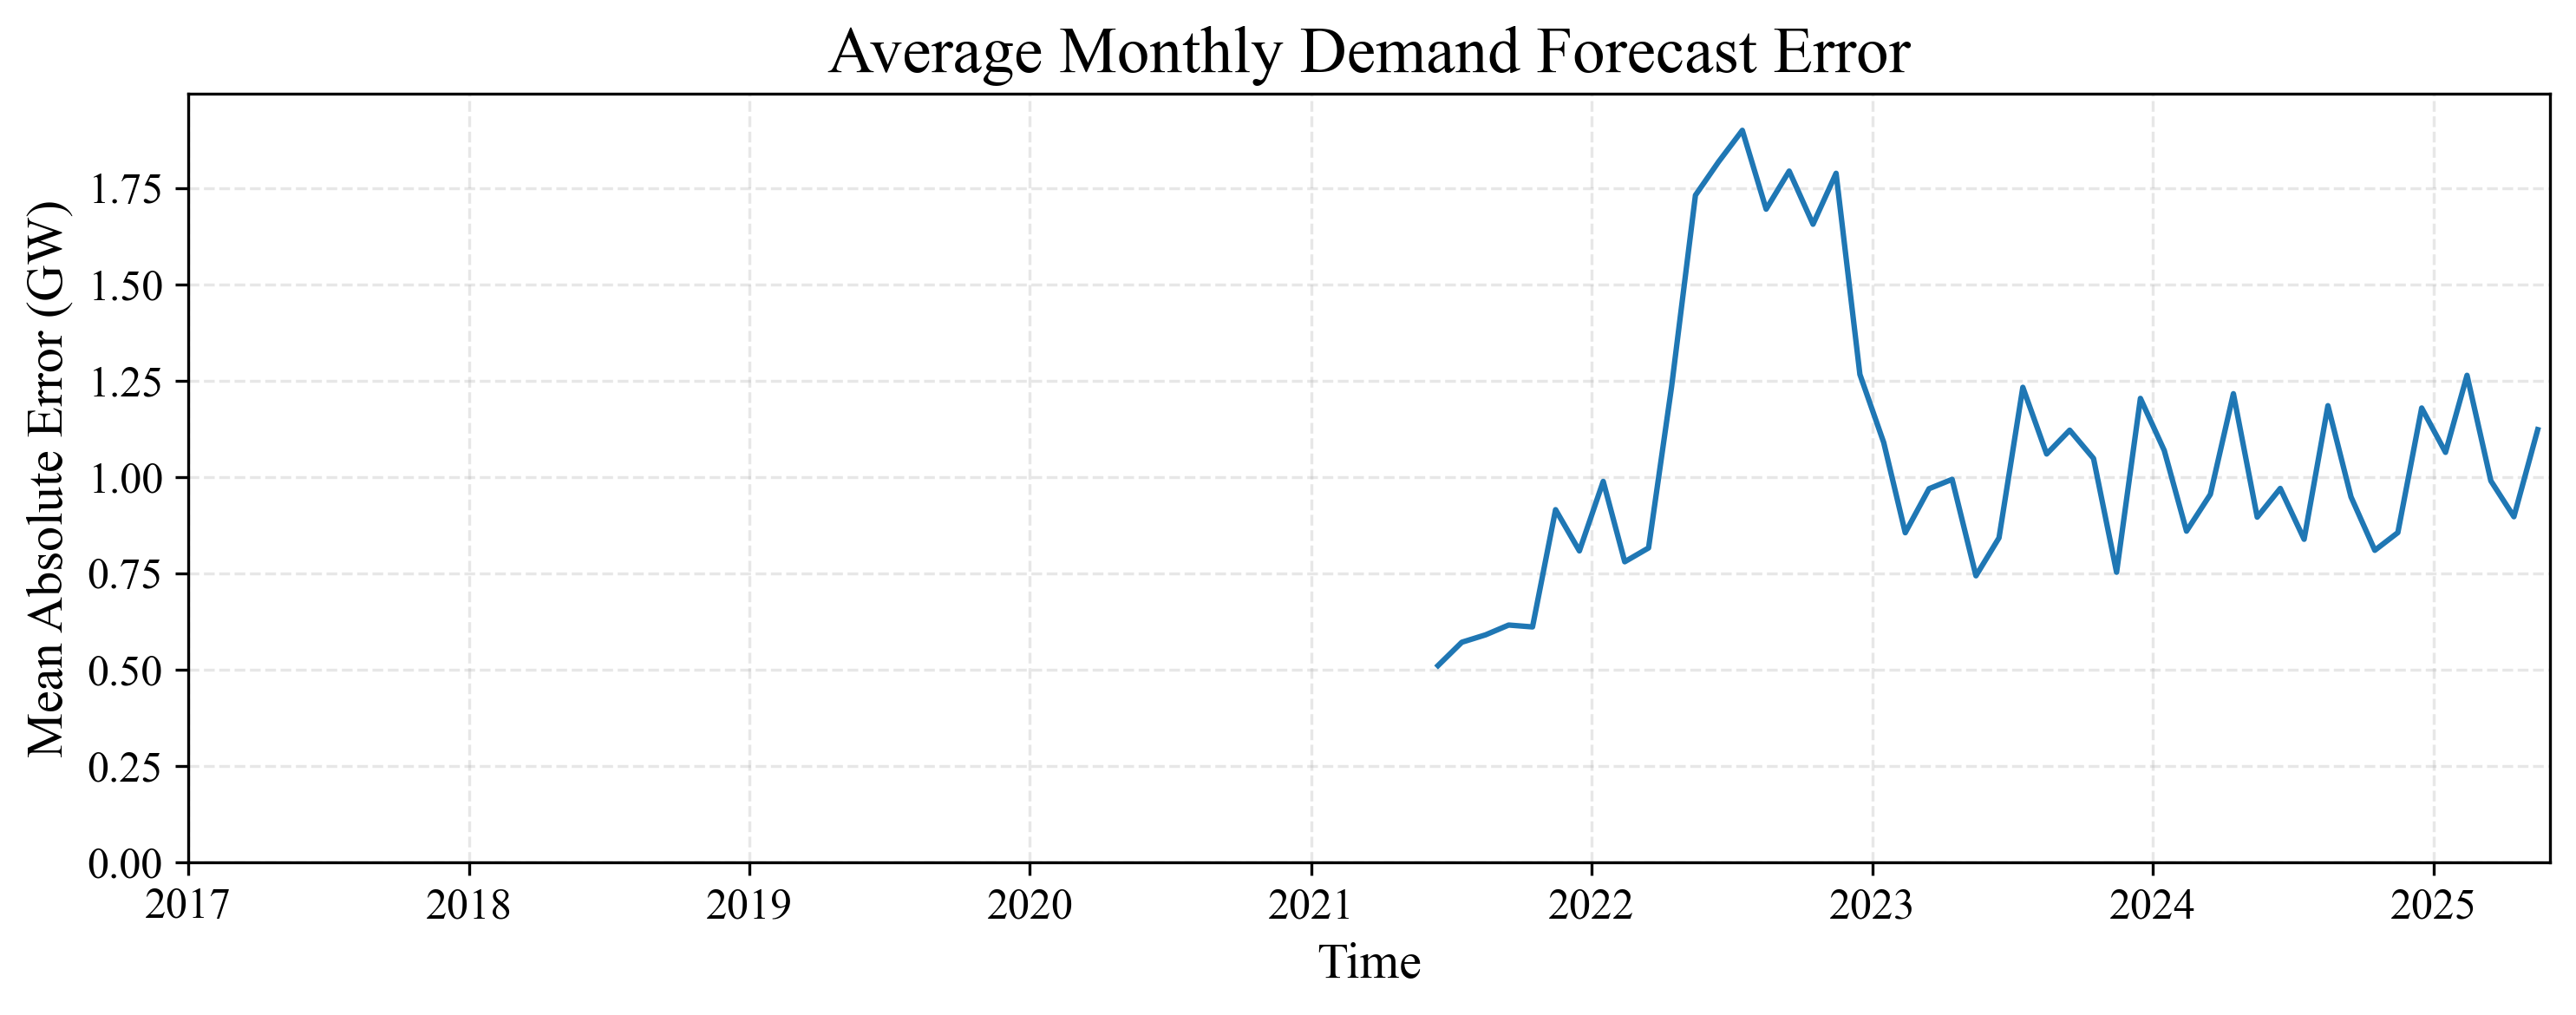

In [108]:
ad_path = CSV_DIR / "ACTUAL_DEMAND.csv"
dd_path = CSV_DIR / "DAYAHEAD_DEMAND.csv"

ad = pd.read_csv(ad_path, parse_dates=["startTime"]).set_index("startTime")
dd = pd.read_csv(dd_path, parse_dates=["startTime"]).set_index("startTime")

# Force NaN for missing values
demand = pd.concat([
    ad["initialTransmissionSystemDemandOutturn"],
    dd["transmissionSystemDemand"]
], axis=1, keys=["act", "fc"])

mask = demand.isna().any(axis=1)
demand[mask] = np.nan

demand_error = (demand["act"] - demand["fc"])

demand_error_abs = (demand["act"] - demand["fc"]).abs()

# Convert to GW
demand_error_gw = demand_error / 1_000

# Resample and shift timestamps to month centres
monthly_demand_error_gw  = demand_error_abs.resample("ME").mean().shift(freq='-15D') / 1_000

# 2) Demand forecast error in GW
plt.figure(figsize=(10, 4))
plt.plot(demand_error_gw.index, demand_error_gw.values, color='tab:blue', linewidth=0.75)
plt.title("Demand Forecast Error")
plt.xlabel("Time")
plt.ylabel("Error (GW)")
plt.xlim(demand_error_gw.index.min(), demand_error_gw.index.max())
plt.ylim(demand_error_gw.min() * 1.05, demand_error_gw.max() * 1.05)
plt.tight_layout()
plt.show()

# 3) Average monthly error in GW
plt.figure(figsize=(10, 4))
plt.plot(monthly_demand_error_gw.index,  monthly_demand_error_gw.values)
plt.title("Average Monthly Demand Forecast Error")
plt.xlabel("Time")
plt.ylabel("Mean Absolute Error (GW)")
plt.xlim(demand_error_gw.index.min(), demand_error_gw.index.max())
plt.ylim(0, monthly_demand_error_gw.max() * 1.05)
plt.tight_layout()
plt.show()


### Inter Delta

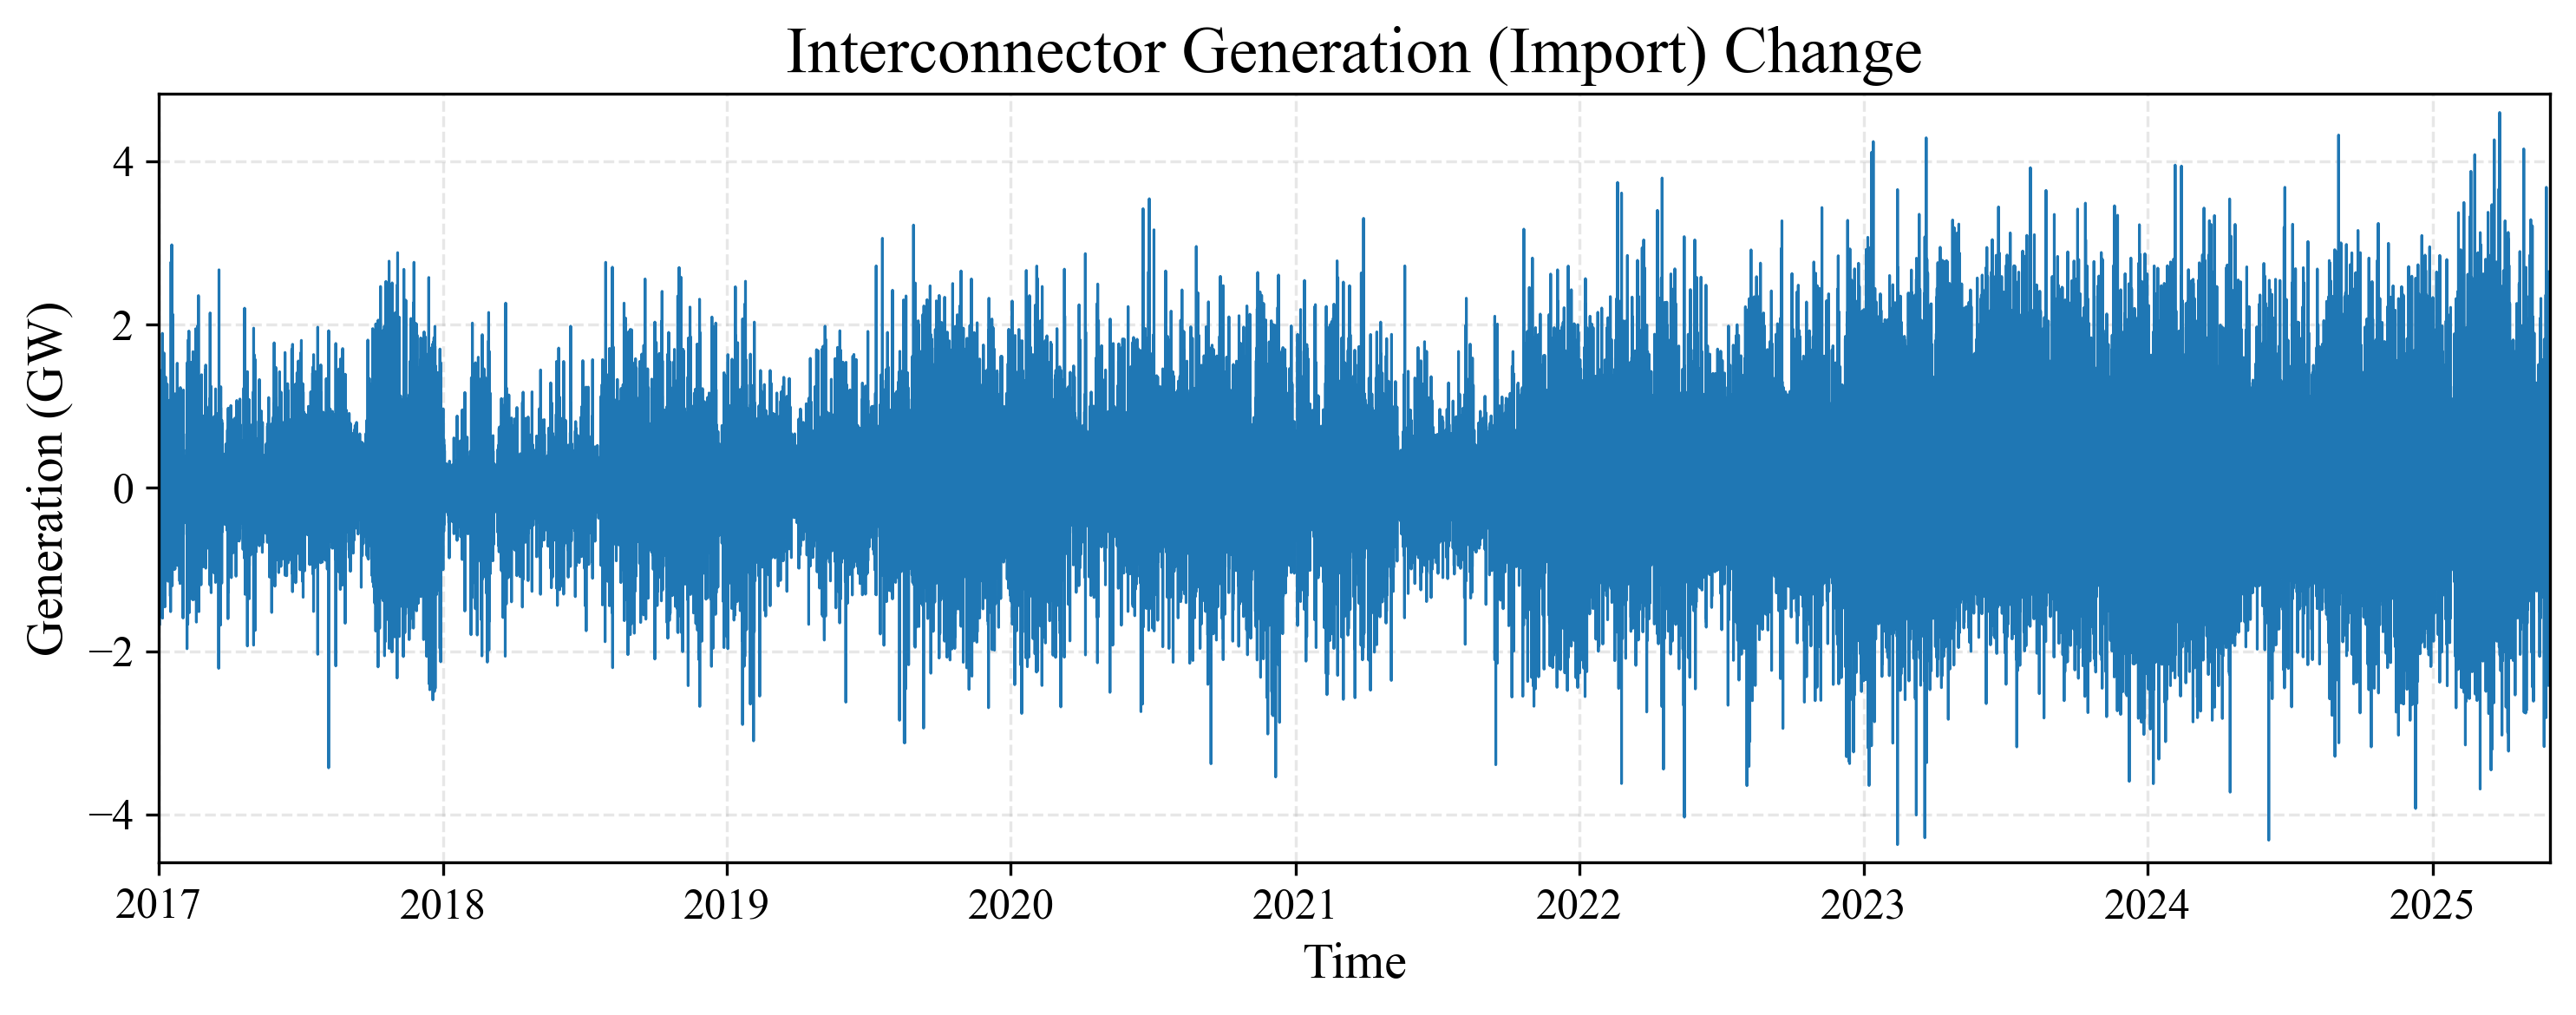

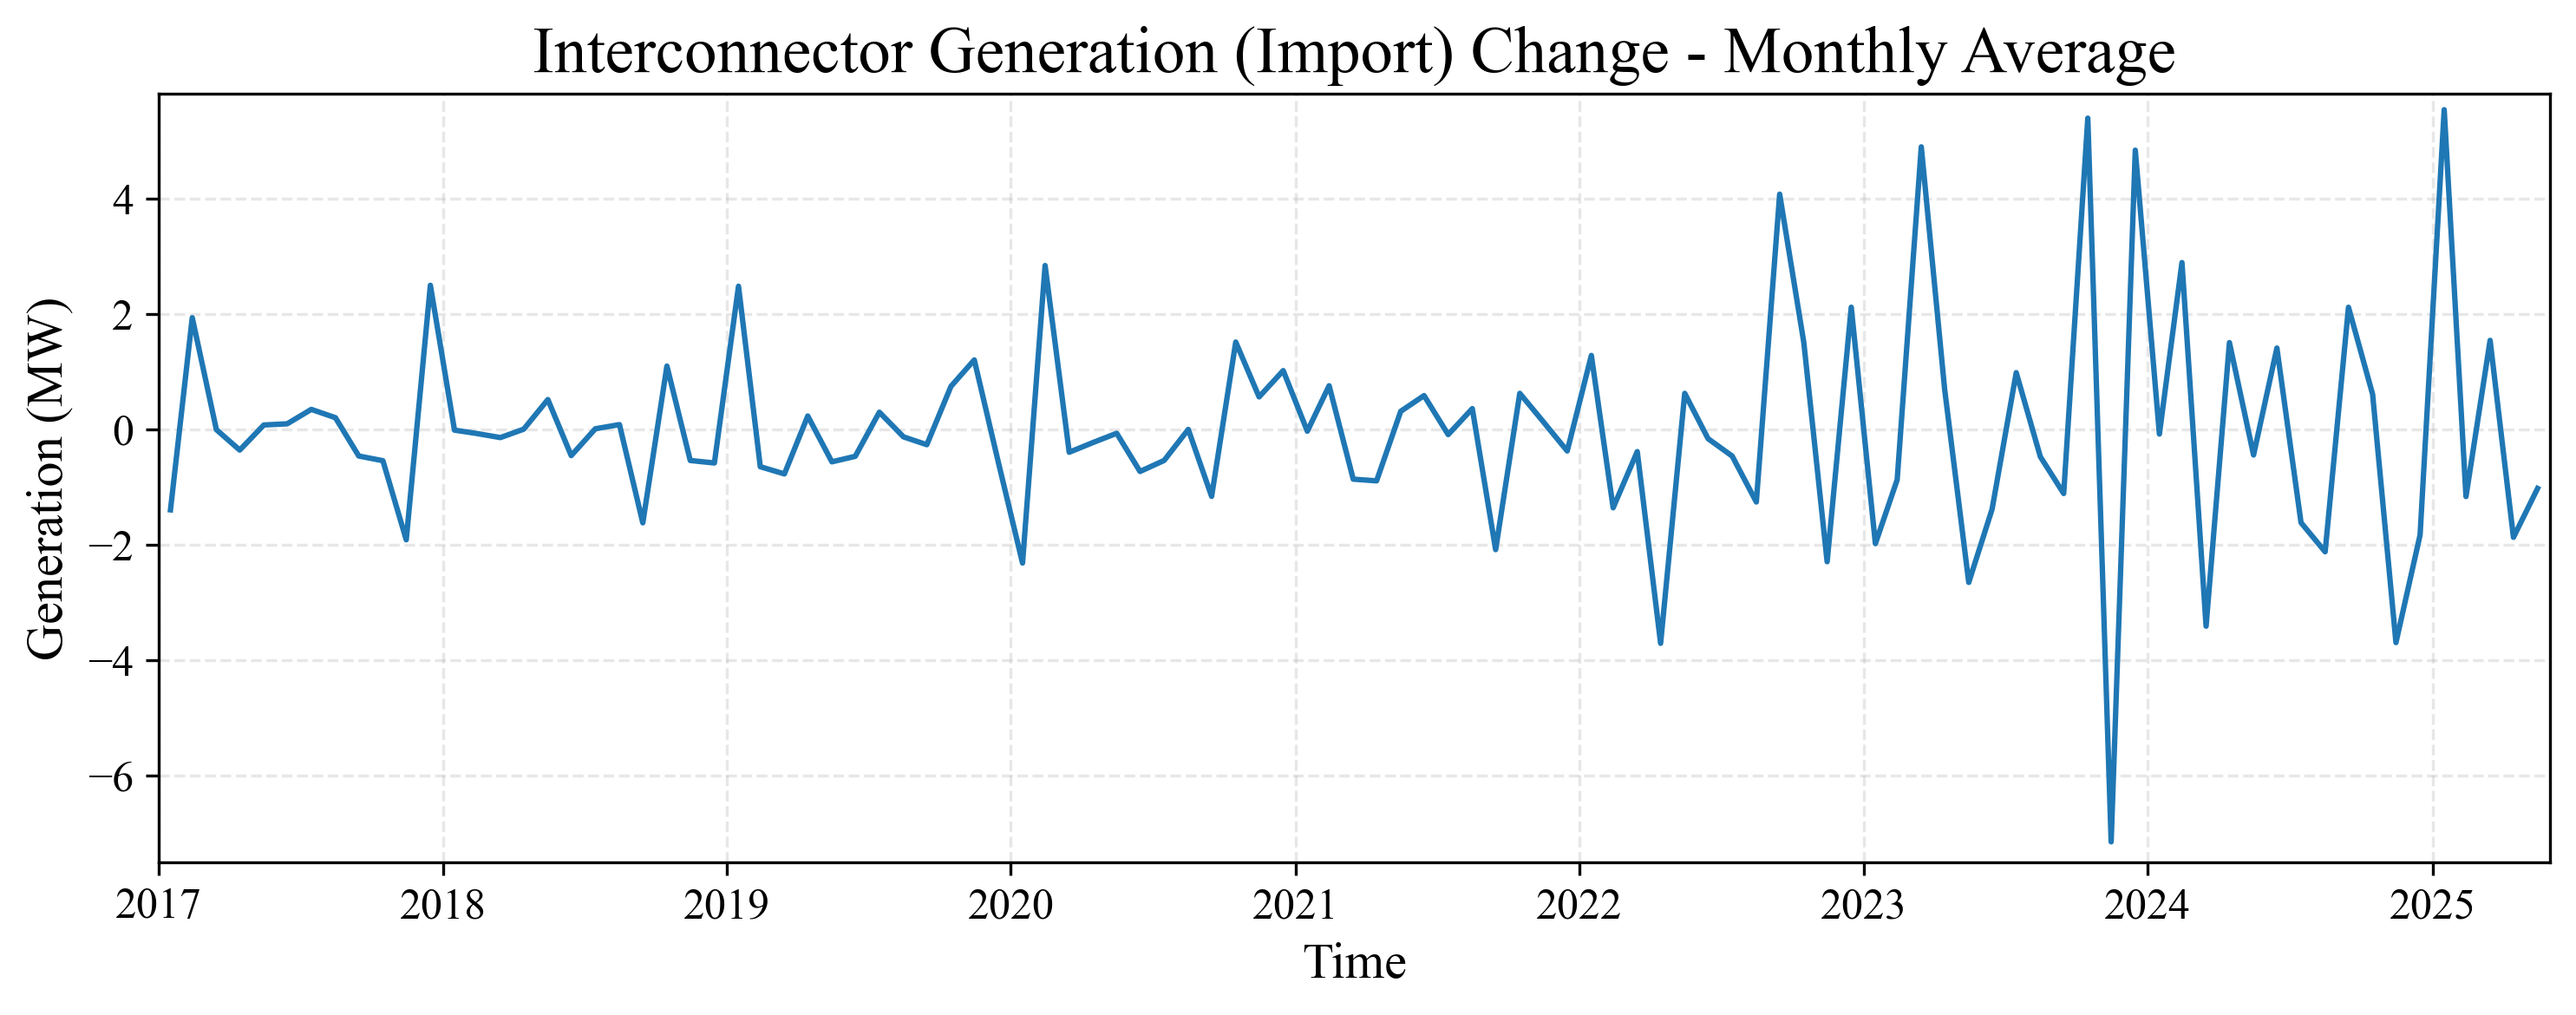

In [76]:
inter_path = CSV_DIR / "INTER.csv"

inter = pd.read_csv(inter_path, parse_dates=["startTime"]).set_index("startTime")

inter["totalInterGen"] = inter.filter(like="INT").sum(axis=1)

inter_gw = inter["totalInterGen"] / 1_000  # Convert to GW

inter_delta_gw = inter["totalInterGen"].diff().fillna(0) / 1_000  # Convert to GW

monthly_inter_delta = inter_delta_gw.resample("ME").mean().shift(freq='-15D') * 1_000

plt.figure(figsize=(10, 4))
plt.plot(inter_delta_gw.index,  inter_delta_gw.values, color='tab:blue', linewidth=0.75)
plt.title("Interconnector Generation (Import) Change")
plt.xlabel("Time")
plt.ylabel("Generation (GW)")
plt.xlim(inter_delta_gw.index.min(), inter_delta_gw.index.max())
plt.ylim(inter_delta_gw.min() * 1.05, inter_delta_gw.max() * 1.05)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(monthly_inter_delta.index,  monthly_inter_delta.values, color='tab:blue')
plt.title("Interconnector Generation (Import) Change - Monthly Average")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.xlim(inter_delta_gw.index.min(), inter_delta_gw.index.max())
plt.ylim(monthly_inter_delta.min() * 1.05, monthly_inter_delta.max() * 1.05)
plt.tight_layout()
plt.show()

# Z-Score

In [113]:
df_all = pd.concat([
    demand_error,
    wind_error,
    solar_error,
    price,
    volume,
    wholesale
], axis=1)

df_all.columns = [
    "Demand Error",
    "Wind Error",
    "Solar Error",
    "Imbalance Price",
    "Imbalance Volume",
    "Wholesale Market Price"
]

# 1) Z-score normalise
df_z = (df_all - df_all.mean()) / df_all.std()

In [ ]:
from ipywidgets import HBox, Checkbox, interactive_output
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Create a checkbox for each variable
checkboxes = [Checkbox(value=True, description=col) for col in df_z.columns]

# 2) Function to read checked items and plot
def plot_selected(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    added_any = False
    for name, checked in kwargs.items():
        if checked:
            ax.plot(df_z.index, df_z[name], label=name, linewidth=0.5, alpha=0.8)
    ax.set_xlabel("Time")
    ax.set_ylabel("Z-score")
    ax.set_xlim(df_z.index.min(), df_z.index.max())
    ax.legend(loc="upper left", ncol=2)

    if added_any:
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# 3) Build interactive plot output
cb_dict = {cb.description: cb for cb in checkboxes}
output = interactive_output(plot_selected, cb_dict)

# 4) Display
display(HBox(checkboxes), output)


Output()

In [124]:
from ipywidgets import HBox, Checkbox, interactive_output
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Create checkboxes for each series
checkboxes = [Checkbox(value=False, description=col) for col in df_z.columns]

# 2) Define plotting function
def plot_bell_curves(**kwargs):
    fig, ax = plt.subplots(figsize=(10, 5))
    added_any = False

    for name, checked in kwargs.items():
        if checked:
            data = df_z[name].dropna()
            ax.hist(
                data,
                bins=100,
                density=True,
                alpha=0.5,
                label=name,
                linewidth=0.75,
                histtype="stepfilled"
            )
            added_any = True

    ax.set_xlabel("Z-score")
    ax.set_ylabel("Density")
    ax.set_title("Z-Score Distributions")

    if added_any:
        ax.legend()

    plt.tight_layout()
    plt.show()

# 3) Build checkbox dictionary and interactive plot
cb_dict = {cb.description: cb for cb in checkboxes}
output = interactive_output(plot_bell_curves, cb_dict)

# 4) Display checkboxes in a row and the output
display(HBox(checkboxes), output)


Output()

In [143]:
import numpy as np

# List of columns and labels
cols = [
    "Demand Error",
    "Wind Error",
    "Solar Error",
    "Imbalance Price",
    "Imbalance Volume",
    "Wholesale Market Price"
]

# Helper to calculate stats
def get_stats(df, label):
    stats = df[cols].agg(["mean", "std", "min", "max"]).T.reset_index()
    stats.insert(0, "Condition", label)
    return stats.rename(columns={"index": "Variable", "std": "stddev"})

# Calculate stats for all, short, and long conditions
all_stats   = get_stats(df_all, "All")
short_stats = get_stats(df_all[df_all["Imbalance Volume"] > 0], "Short (NIV > 0)")
long_stats  = get_stats(df_all[df_all["Imbalance Volume"] < 0], "Long (NIV < 0)")

# Combine and preserve float types by inserting np.nan instead of ""
combined_stats = pd.concat([all_stats, short_stats, long_stats])

output_rows = []
for var in cols:
    chunk = combined_stats[combined_stats["Variable"] == var]
    output_rows.append(chunk)
    output_rows.append(
        pd.DataFrame([{
            "Condition": "", "Variable": "",
            "mean": np.nan, "stddev": np.nan,
            "min": np.nan, "max": np.nan
        }])
    )

final_table = pd.concat(output_rows, ignore_index=True)
final_table.round(2)


Condition                Variable     mean   stddev       min  \
0               All            Demand Error   451.87  1523.12  -5917.00   
1   Short (NIV > 0)            Demand Error   377.62  1423.72  -5917.00   
2    Long (NIV < 0)            Demand Error   525.23  1612.14  -5801.00   
3                                                NaN      NaN       NaN   
4               All              Wind Error -2231.78  2729.15 -20410.22   
5   Short (NIV > 0)              Wind Error -2402.21  2695.21 -20410.22   
6    Long (NIV < 0)              Wind Error -2078.94  2750.38 -20362.89   
7                                                NaN      NaN       NaN   
8               All             Solar Error   -39.32   390.66  -6096.00   
9   Short (NIV > 0)             Solar Error   -97.95   384.45  -4988.00   
10   Long (NIV < 0)             Solar Error    13.32   388.66  -6096.00   
11                                               NaN      NaN       NaN   
12              All         Imbalance Price    82.64    97.38   -185.33   
13  Short (NIV > 0)         Imbalance Price   120.97   121.90    -30.99   
14   Long (NIV < 0)         Imbalance Price    48.01    45.80   -185.33   
15                                               NaN      NaN       NaN   
16              All        Imbalance Volume   -25.94   332.32  -2283.46   
17  Short (NIV > 0)        Imbalance Volume   235.71   213.79      0.00   
18   Long (NIV < 0)        Imbalance Volume  -262.41   226.18  -2283.46   
19                                               NaN      NaN       NaN   
20              All  Wholesale Market Price    82.59    73.20    -77.29   
21  Short (NIV > 0)  Wholesale Market Price    95.08    80.38    -32.93   
22   Long (NIV < 0)  Wholesale Market Price    71.30    63.98    -77.29   
23                                               NaN      NaN       NaN   

        max  
0   8071.00  
1   7630.00  
2   8071.00  
3       NaN  
4   9012.93  
5   7413.74  
6   9012.93  
7       NaN  
8   3127.00  
9   3127.00  
10  3031.00  
11      NaN  
12  4037.80  
13  4037.80  
14   576.68  
15      NaN  
16  2477.17  
17  2477.17  
18    -0.00  
19      NaN  
20  1983.66  
21  1983.66  
22  1795.98  
23      NaN